In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
DIR2LOAD = Path(
    "/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/prepareInputRNA/"
)
DIR2LOAD.mkdir(parents=True, exist_ok=True)

In [3]:
FIG2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/final_object/figures/forpaper/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)

In [4]:
adata_liver = sc.read_h5ad(
    DIR2LOAD.joinpath("Multiome_Che_Wu_CRC_LM_annotations_raw.h5ad")
)

In [5]:
adata_liver.obs.cell_source.value_counts()

Wu-Cells      49302
Che-Cells     43984
BCI-Nuclei    21035
Name: cell_source, dtype: int64

In [6]:
adata_multiome = adata_liver[adata_liver.obs.cell_source=="BCI-Nuclei"].copy()
adata_multiome.shape

(21035, 39559)

In [7]:
adata_multiome.obs.Annotation_scVI.value_counts()

Epithelial     16009
Myeloid         1828
T-NK-ILC        1560
Stromal          549
Endothelial      489
Hepatocyte       437
B                 98
Plasma            64
Mast               1
Name: Annotation_scVI, dtype: int64

In [8]:
# remove mast
adata_multiome = adata_multiome[adata_multiome.obs.Annotation_scVI!="Mast"].copy()
adata_multiome.shape

(21034, 39559)

In [9]:
adata_multiome.obs.Annotation_scVI_detailed.value_counts()

TA1                  4116
Hypoxia              2481
Stem (NOTUM high)    1933
Colonocyte           1913
Stem                 1400
Intermediate         1319
SPP1 Mac             1276
pEMT                  998
UPR                   759
ipEMT                 469
CD4 Th                409
ECM CAF               370
Hepatocyte            338
CD8 Tem               336
Goblet                323
Tip-like endo         241
C1QC Mac              200
Treg                  196
CD8 Tem GZMB          162
TA2                   162
CD4 Tfh               135
CD8 Tex               125
SEC                   113
Cholangiocyte          99
B                      98
Myofibroblast          75
Stalk-like endo        73
Myeloid cycling        72
Enteroendocrine        71
Tuft                   65
Plasma                 64
Neutrophil             63
Lymphatic endo         62
T cycling              51
C3 iCAF                44
cDC2                   34
CD4 Tn                 34
SMC                    33
IL1B Mac    

In [10]:
# maybe create a new column where we have cancer cell states and general TME annot?
adata_multiome.obs["Annot_majorTME_cancer_states"] = np.where(
    adata_multiome.obs["Annotation_scVI"]=="Epithelial",
    adata_multiome.obs["Annotation_scVI_detailed"],  
    adata_multiome.obs["Annotation_scVI"])

In [36]:
# get subtypes of TME and cancer cell states that have at least nbcells cells
nbcells = 20
subsets2keep = adata_multiome.obs.Annotation_scVI_detailed.value_counts()[
    adata_multiome.obs.Annotation_scVI_detailed.value_counts()>nbcells].index.values

# only retains subtypes thaat have enough cells "barcodes" to actually look at correlation
adata_multiome_subset = adata_multiome[adata_multiome.obs.Annotation_scVI_detailed.isin(subsets2keep)].copy()

In [37]:
adata_multiome_subset.obs.Annotation_scVI_detailed.value_counts()

TA1                  4116
Hypoxia              2481
Stem (NOTUM high)    1933
Colonocyte           1913
Stem                 1400
Intermediate         1319
SPP1 Mac             1276
pEMT                  998
UPR                   759
ipEMT                 469
CD4 Th                409
ECM CAF               370
Hepatocyte            338
CD8 Tem               336
Goblet                323
Tip-like endo         241
C1QC Mac              200
Treg                  196
CD8 Tem GZMB          162
TA2                   162
CD4 Tfh               135
CD8 Tex               125
SEC                   113
Cholangiocyte          99
B                      98
Myofibroblast          75
Stalk-like endo        73
Myeloid cycling        72
Enteroendocrine        71
Tuft                   65
Plasma                 64
Neutrophil             63
Lymphatic endo         62
T cycling              51
C3 iCAF                44
CD4 Tn                 34
cDC2                   34
SMC                    33
Kupffer     

### Lastly, we asked if there exists an association between the observed macrophage states/TME states and cancer cell states by looking at the correlation between the fraction of the TME cells in different states in each sample, and the fraction of cancer cells in different states in each sample. 

In [11]:
# group by patient and compute fraction 
def proportions_cells_patient(df, groupby_cols):
    prop_df = df.groupby(groupby_cols).size().groupby(level=0).apply(lambda x: x*100/x.sum()).unstack()
    return prop_df

In [12]:
# proportions major cell types
prop_major = proportions_cells_patient(df=adata_multiome.obs, groupby_cols=["Sample", "Annotation_scVI"])
prop_major

Annotation_scVI,B,Endothelial,Epithelial,Hepatocyte,Myeloid,Plasma,Stromal,T-NK-ILC
Sample,,,,,,,,
CRC01_LM,0.000000,1.117318,95.530726,0.000000,3.072626,0.000000,0.000000,0.279330
CRC02_LM,0.108108,6.054054,76.324324,1.405405,5.189189,0.216216,6.378378,4.324324
CRC03_LM,0.529101,2.248677,59.788360,5.687831,20.899471,0.000000,3.571429,7.275132
CRC04_LM,0.000000,0.484932,92.760651,0.969865,5.057153,0.000000,0.450294,0.277104
CRC05_LM,0.000000,0.429185,93.562232,0.000000,3.147353,0.000000,1.430615,1.430615
CRC06_LM,0.303721,2.505695,75.702354,6.226272,5.391040,0.151860,3.416856,6.302202
CRC07_LM,0.000000,0.000000,95.824176,0.000000,4.175824,0.000000,0.000000,0.000000
CRC08_LM,0.000000,1.880801,81.167562,0.122130,10.332193,0.000000,2.344895,4.152418
CRC09_LM,2.843602,0.710900,62.701422,1.090047,4.597156,1.469194,1.753555,24.834123


In [13]:
# prop specific cancer states and major TME pop
prop_majorTME_cancer_states = proportions_cells_patient(df=adata_multiome.obs, 
                                                         groupby_cols=["Sample", "Annot_majorTME_cancer_states"])
prop_majorTME_cancer_states

Annot_majorTME_cancer_states,B,Colonocyte,Endothelial,Enteroendocrine,Goblet,Hepatocyte,Hypoxia,Intermediate,Myeloid,Plasma,Stem,Stem (NOTUM high),Stromal,T-NK-ILC,TA1,TA2,Tuft,UPR,ipEMT,pEMT
Sample,,,,,,,,,,,,,,,,,,,,
CRC01_LM,0.000000,0.558659,1.117318,0.000000,0.000000,0.000000,27.932961,4.469274,3.072626,0.000000,0.000000,1.675978,0.000000,0.279330,33.798883,1.396648,0.000000,1.675978,9.776536,14.245810
CRC02_LM,0.108108,1.297297,6.054054,0.000000,1.081081,1.405405,17.297297,34.486486,5.189189,0.216216,4.324324,3.243243,6.378378,4.324324,7.459459,0.756757,0.108108,3.567568,1.297297,1.405405
CRC03_LM,0.529101,0.000000,2.248677,0.661376,1.984127,5.687831,16.798942,7.010582,20.899471,0.000000,0.529101,13.227513,3.571429,7.275132,12.830688,0.793651,0.396825,1.058201,2.645503,1.851852
CRC04_LM,0.000000,25.562868,0.484932,0.000000,1.246969,0.969865,11.395913,5.888466,5.057153,0.000000,14.166955,2.597852,0.450294,0.277104,18.947004,0.415656,0.000000,8.901974,0.865951,2.771043
CRC05_LM,0.000000,4.721030,0.429185,0.000000,15.736767,0.000000,14.878398,9.298999,3.147353,0.000000,1.430615,0.572246,1.430615,1.430615,16.165951,0.715308,0.000000,15.164521,1.144492,13.733906
CRC06_LM,0.303721,5.239180,2.505695,0.000000,2.277904,6.226272,8.352316,4.859529,5.391040,0.151860,2.126044,5.239180,3.416856,6.302202,16.400911,0.911162,0.000000,5.542901,17.615793,7.137434
CRC07_LM,0.000000,1.538462,0.000000,0.000000,4.175824,0.000000,16.043956,4.175824,4.175824,0.000000,0.439560,1.318681,0.000000,0.000000,53.626374,0.000000,0.879121,13.186813,0.000000,0.439560
CRC08_LM,0.000000,21.568149,1.880801,1.563263,0.293112,0.122130,9.916952,5.862237,10.332193,0.000000,15.315095,6.521739,2.344895,4.152418,14.680020,0.757206,0.219834,0.806058,1.514411,2.149487
CRC09_LM,2.843602,3.933649,0.710900,0.000000,0.236967,1.090047,1.090047,4.265403,4.597156,1.469194,8.578199,13.033175,1.753555,24.834123,28.104265,0.331754,0.000000,1.800948,1.042654,0.284360


In [38]:
prop_subsets = proportions_cells_patient(df=adata_multiome_subset.obs, 
                                         groupby_cols=["Sample", "Annotation_scVI_detailed"])

### To decide which correlation coefficient to compute, we plot the distribution of the different categories

1. Pearson correlation coefficient assumes that the data are following a Normal (Gaussian) distribution.  summarize the strength of the linear relationship between two data samples.

Pearson’s correlation coefficient is calculated by dividing the covariance of the two variables by the product of their respective standard deviations. It is the normalization of the covariance between the two variables to give an interpretable score.

2. While many data relationships can be linear, some may be nonlinear. These nonlinear relationships are stronger or weaker across the distribution of the variables. Further, the two variables being considered may have a non-Gaussian distribution.

Spearman’s correlation coefficient can be used to summarize the strength between the two data samples. This test of relationship can also be used if there is a linear relationship between the variables but will have slightly less power (e.g. may result in lower coefficient scores).

As with the Pearson correlation coefficient, the scores are between -1 and 1 for perfectly negatively correlated variables and perfectly positively correlated respectively.

Instead of directly working with the data samples, it operates on the relative ranks of data values. This is a common approach used in non-parametric statistics, e.g. statistical methods where we do not assume a distribution of the data such as Gaussian.

A linear relationship between the variables is not assumed, although a monotonic relationship is assumed. This is a mathematical name for an increasing or decreasing relationship between the two variables.

If you are unsure of the distribution and possible relationships between two variables, the Spearman correlation coefficient is a good tool to usee

In [14]:
# plot distribution of the cell types
def plot_distribution_prop_celltype(df, name2save):
    
    for celltype in df:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, dpi=DPI)
        sns.histplot(df, x=celltype, color='#67A9CF', ax=ax, edgecolor="black").set(title=celltype)
        ax.set_xlabel('Proportion')
        plt.savefig(FIG2SAVE.joinpath(f"histogram_proportions_{name2save}_{celltype}.pdf"), 
                    dpi=DPI, 
                    format="pdf",
                    bbox_inches="tight")
        plt.show()

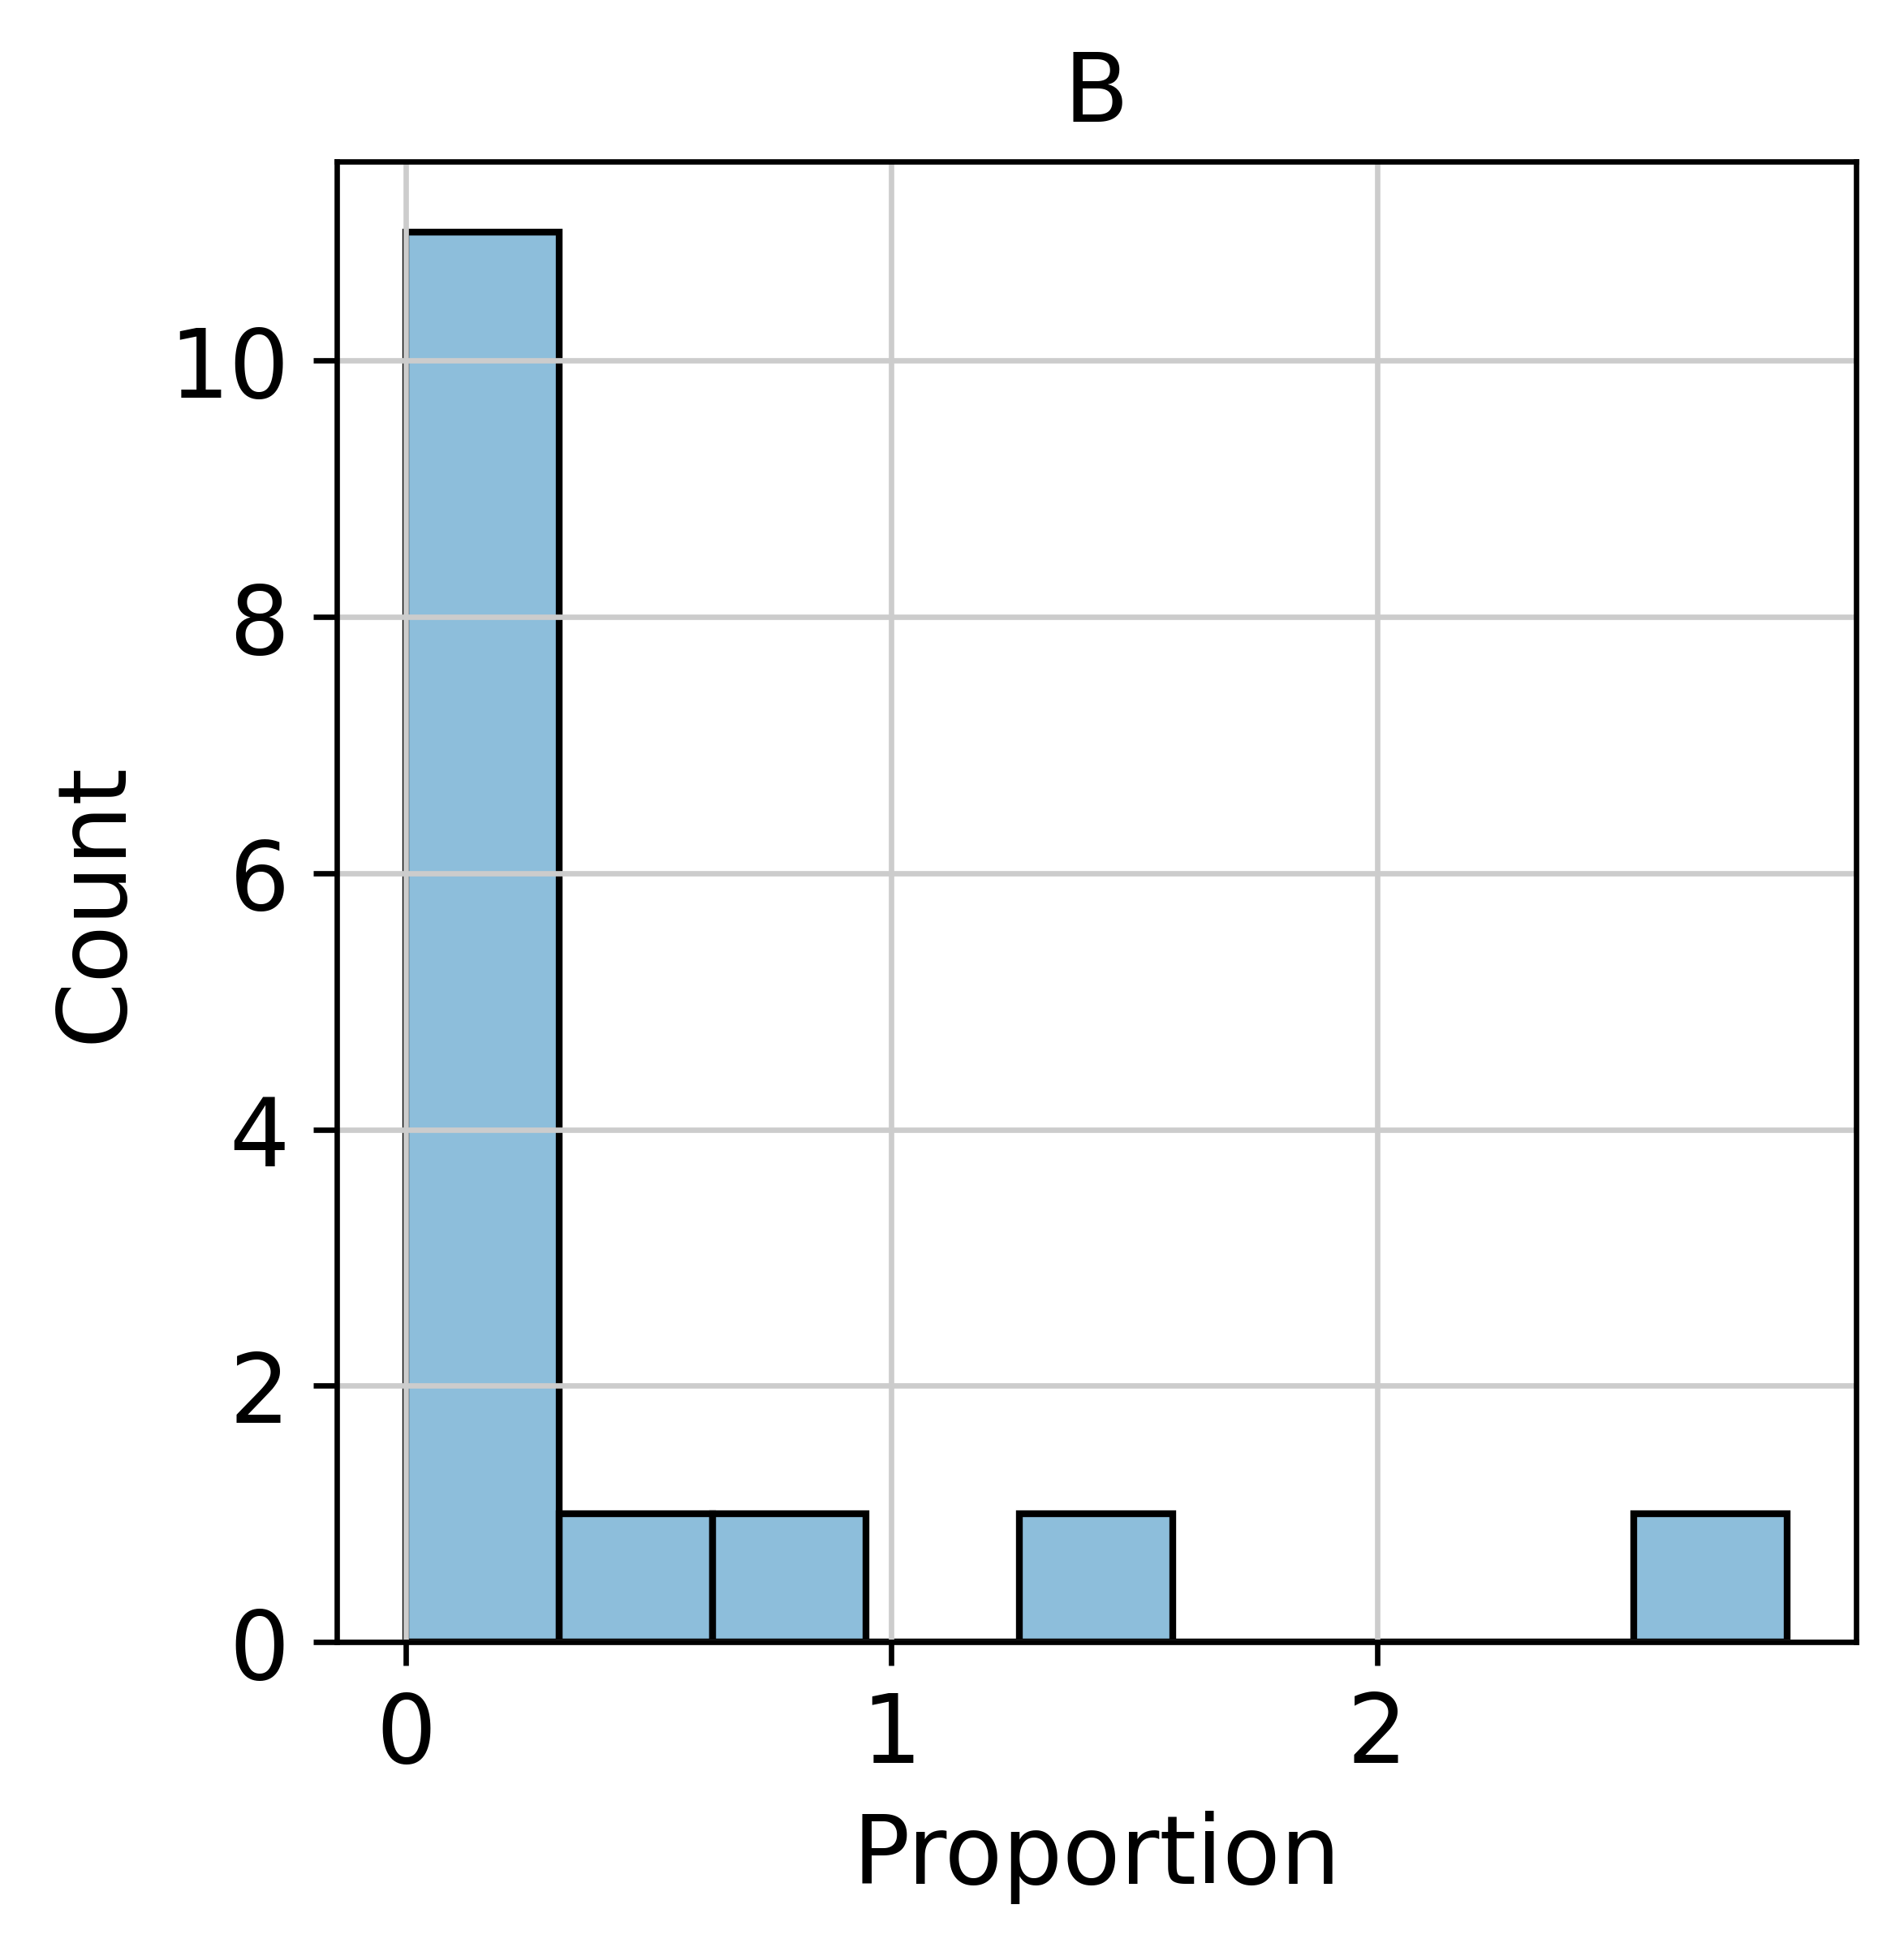

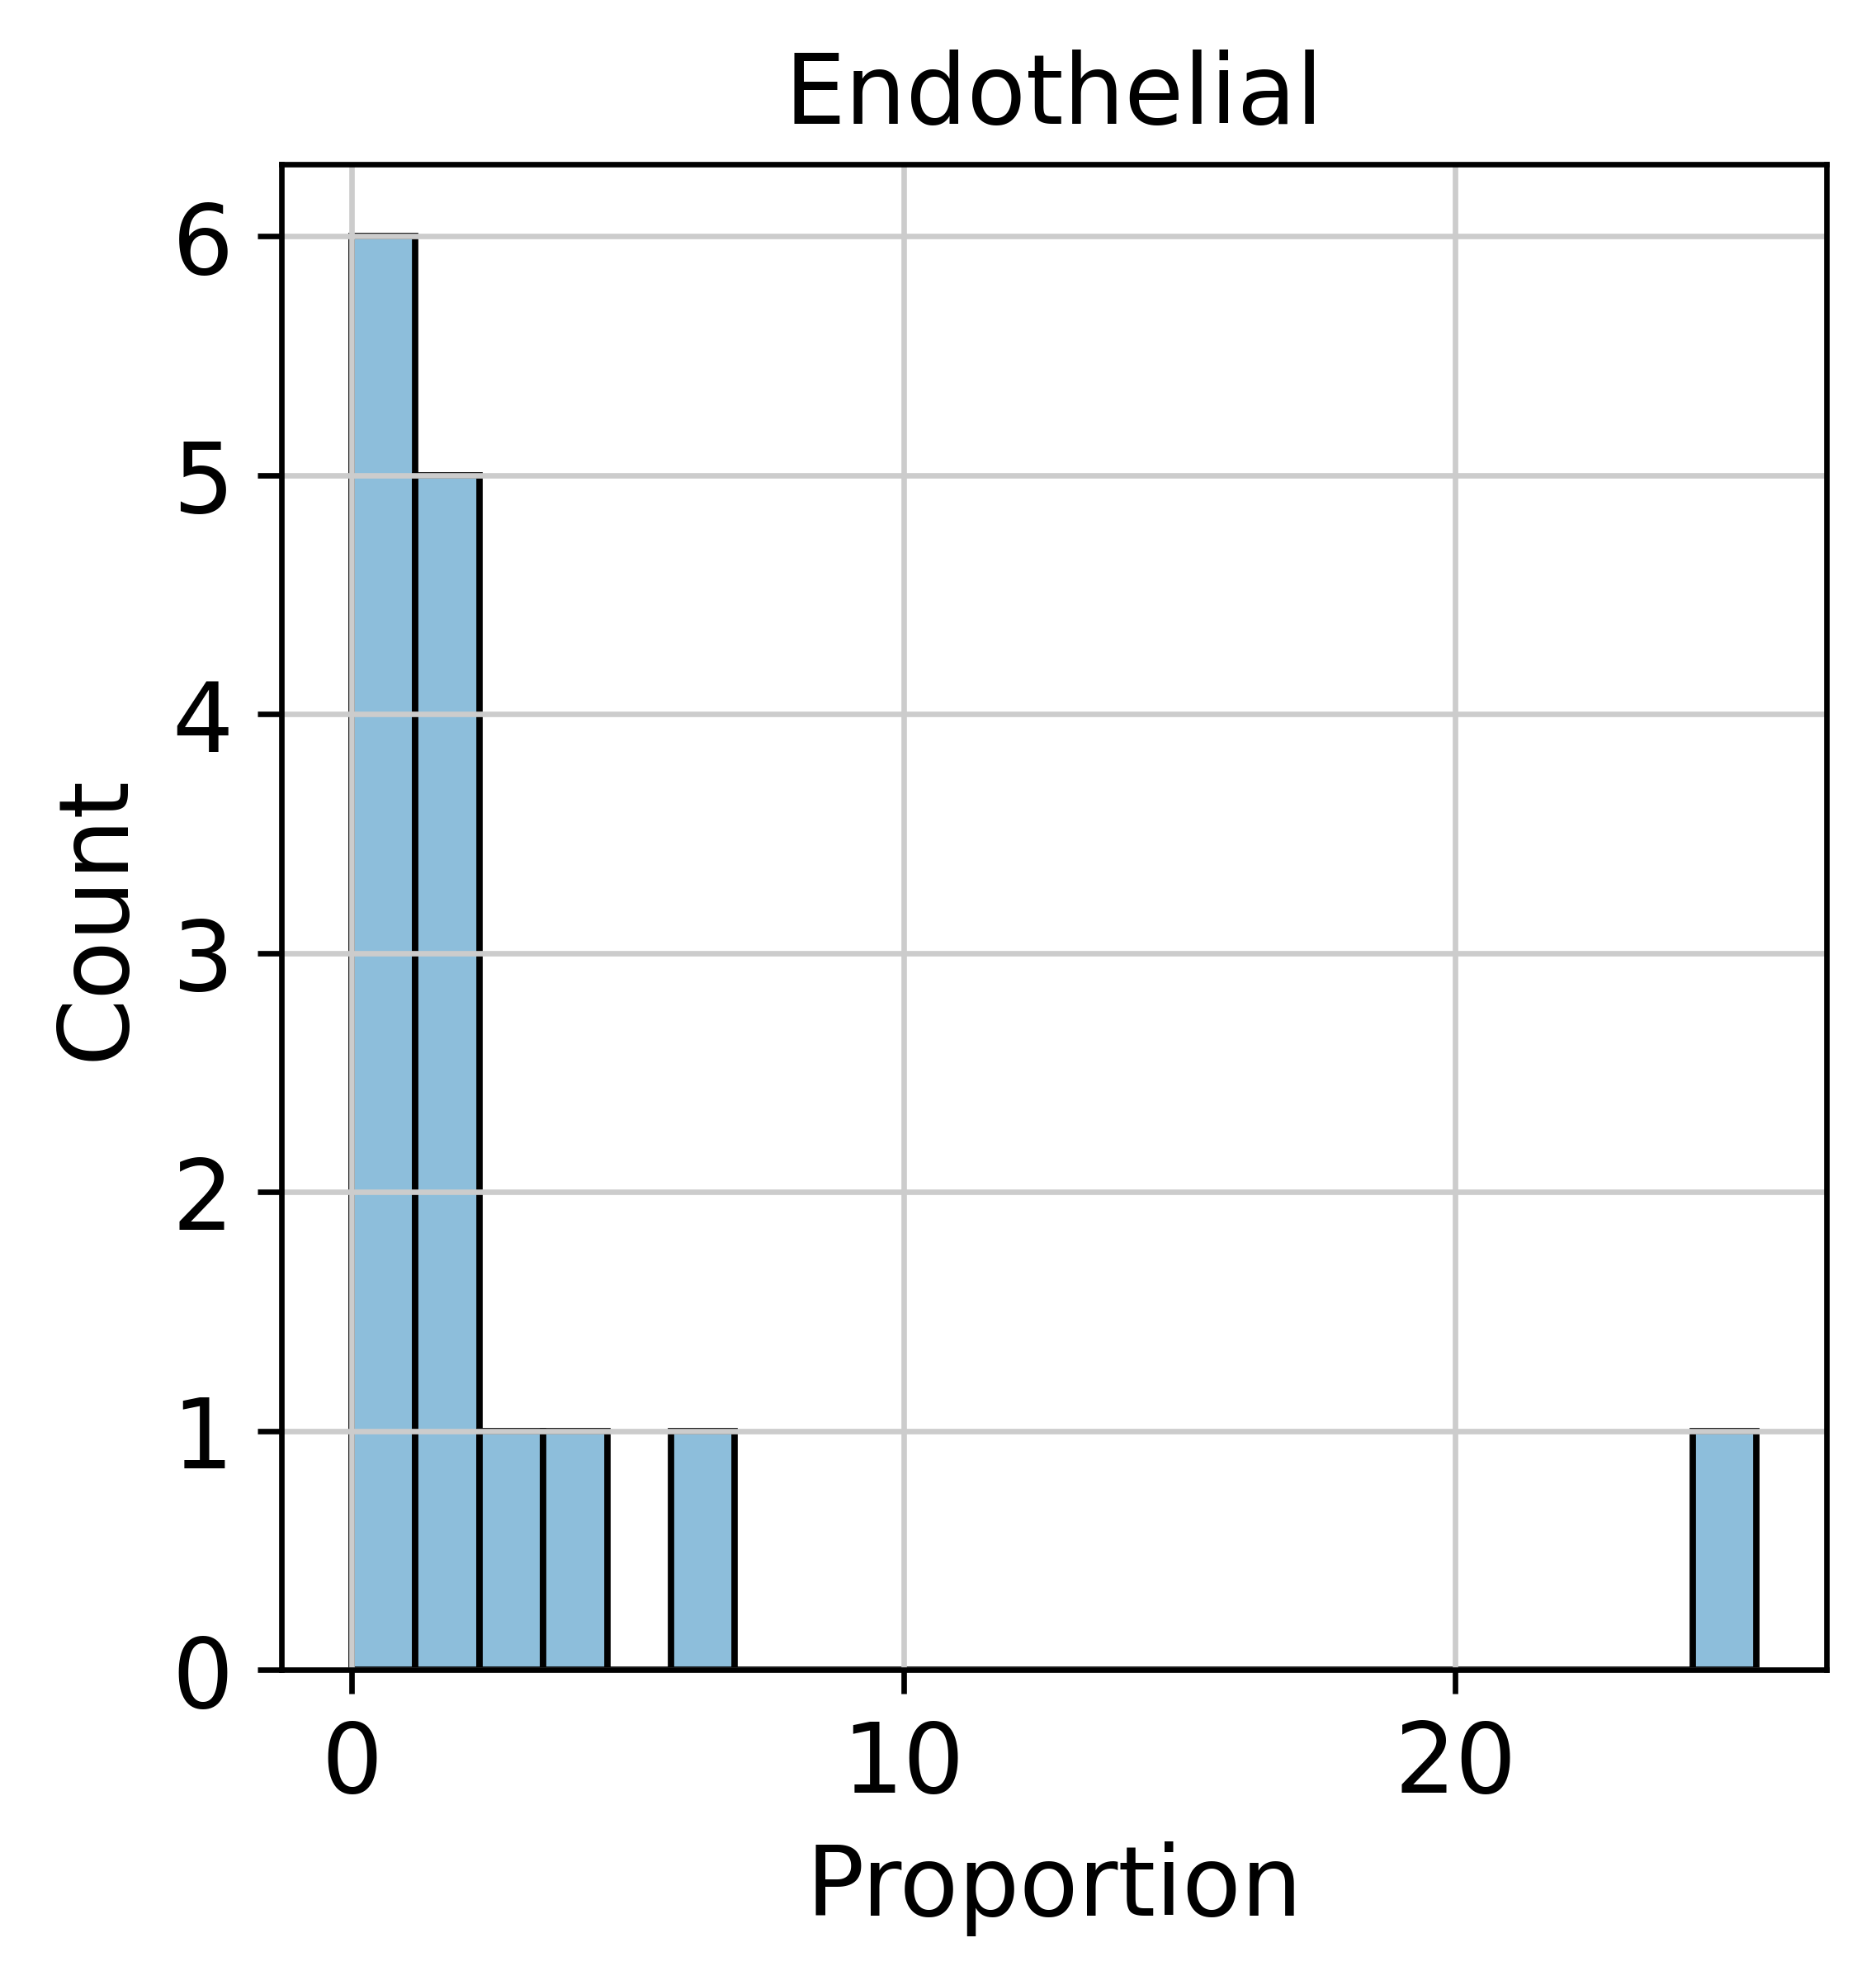

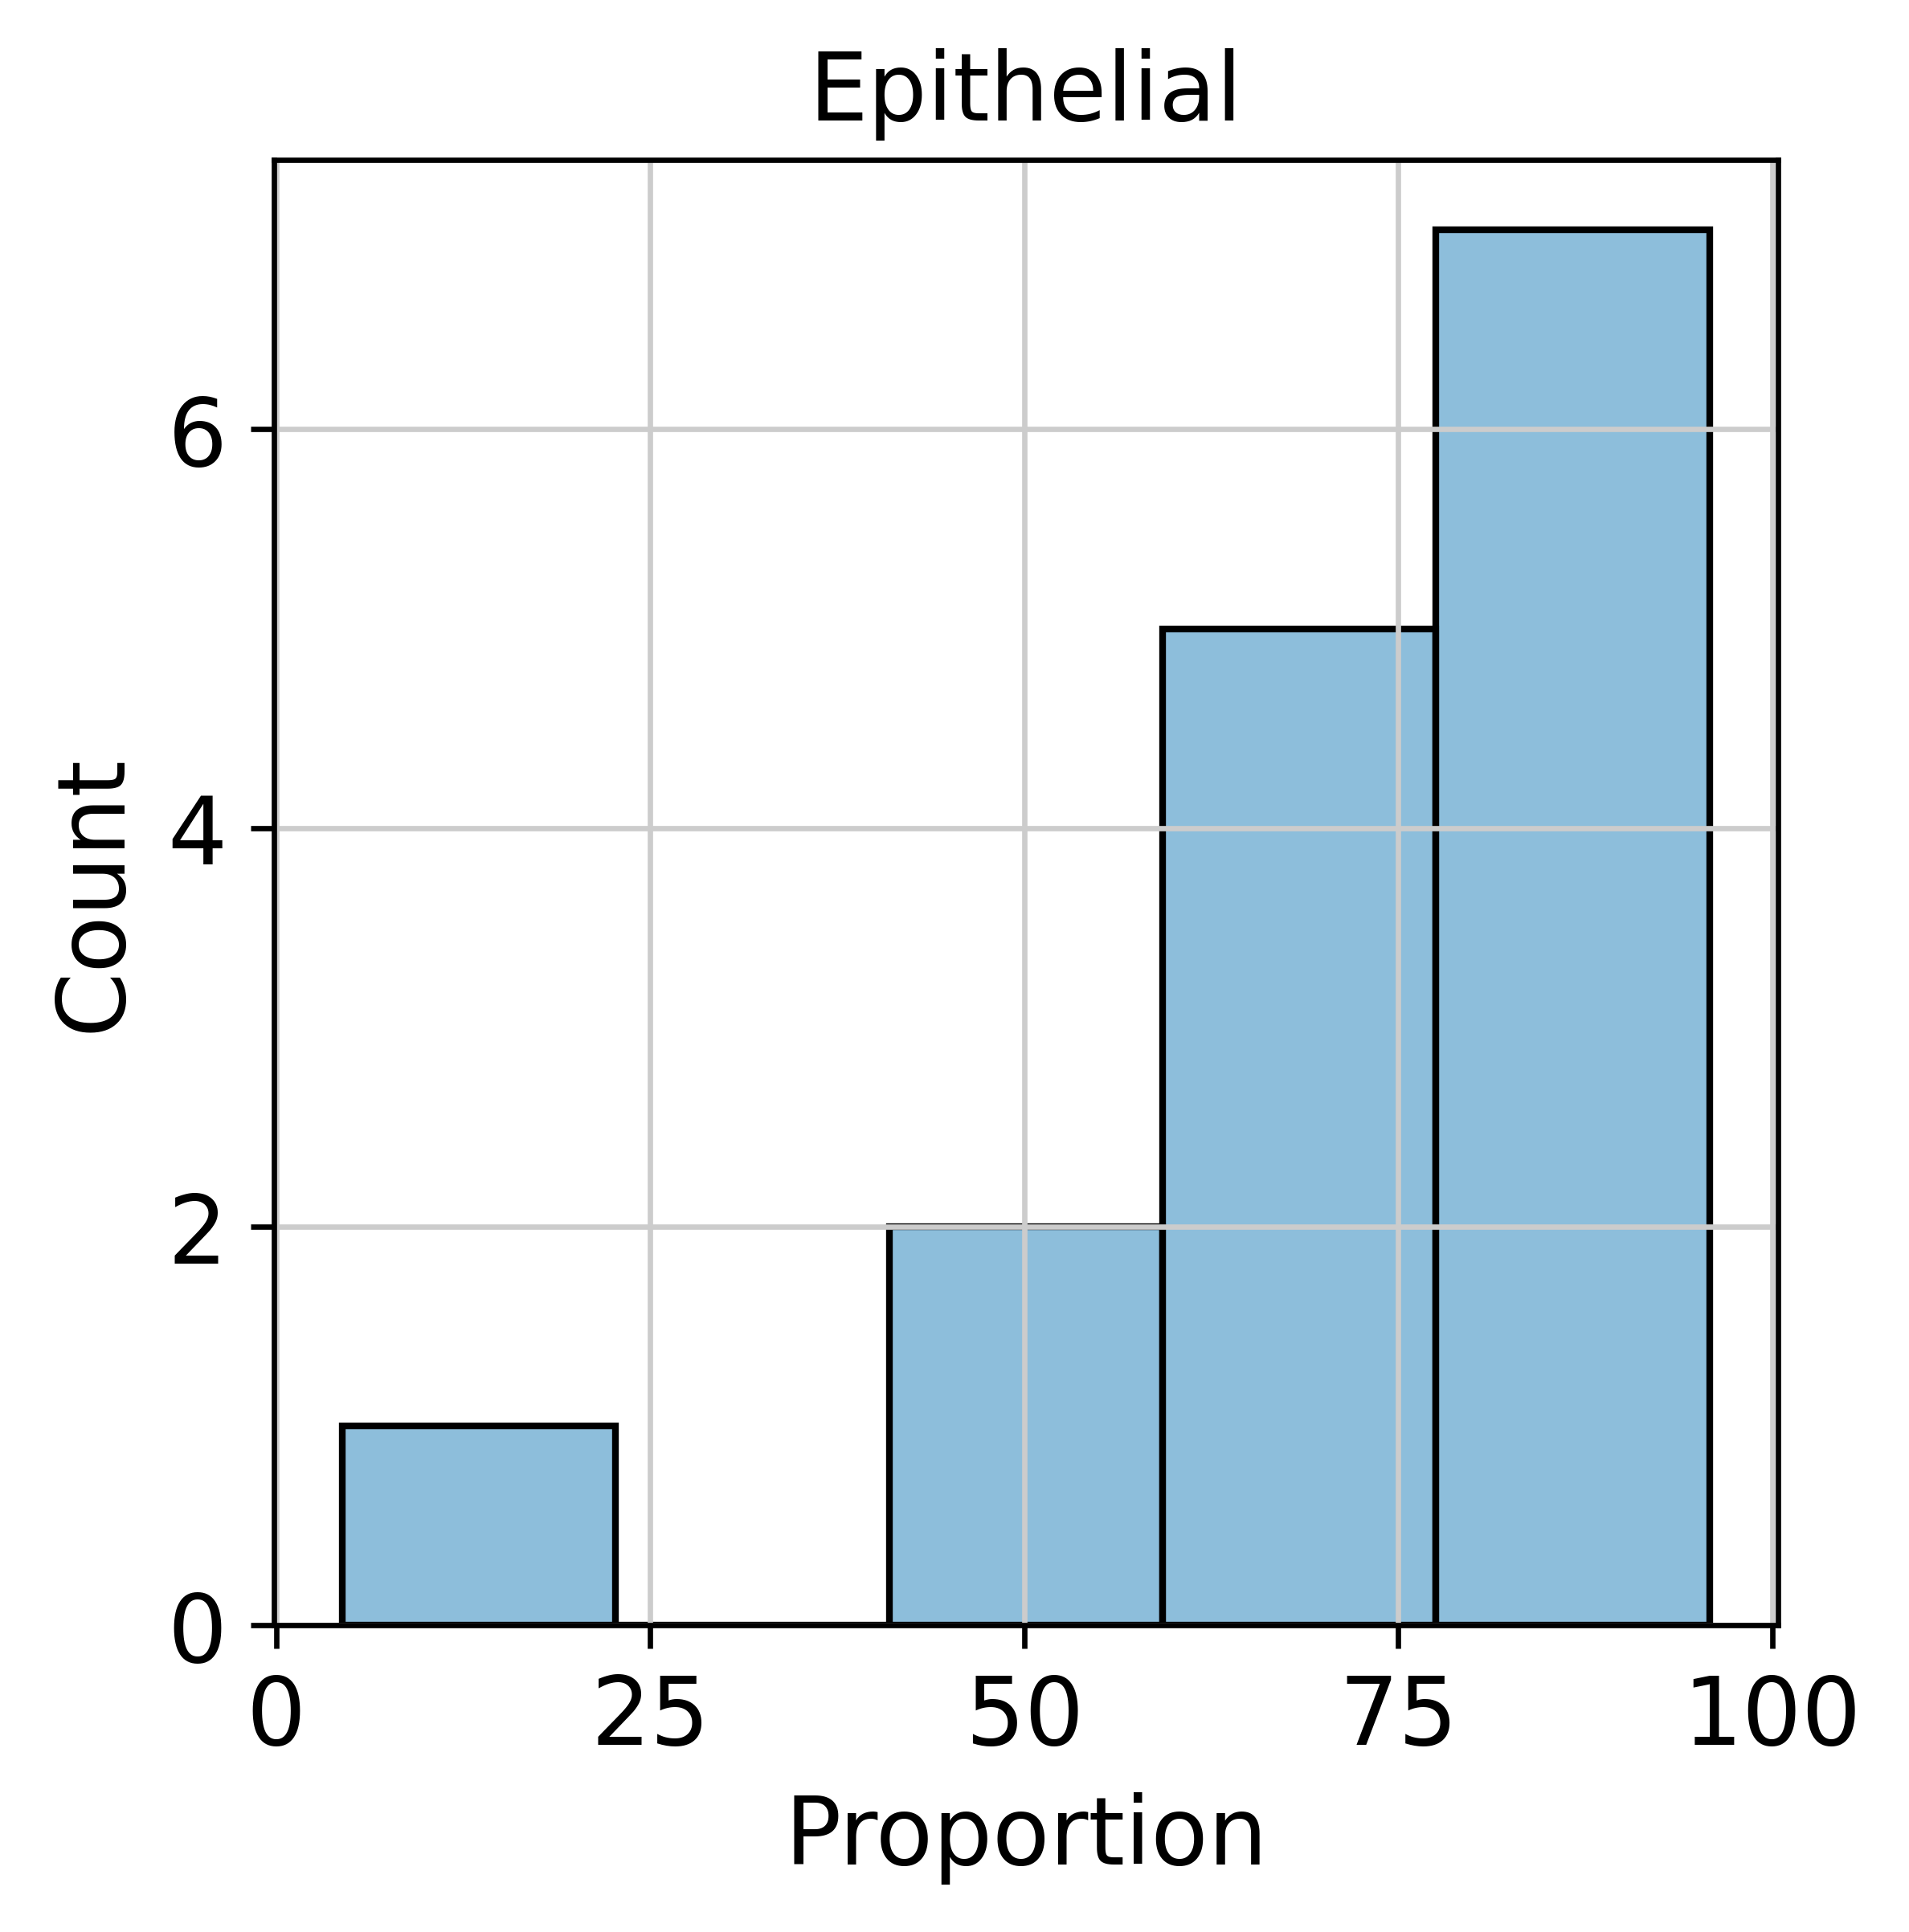

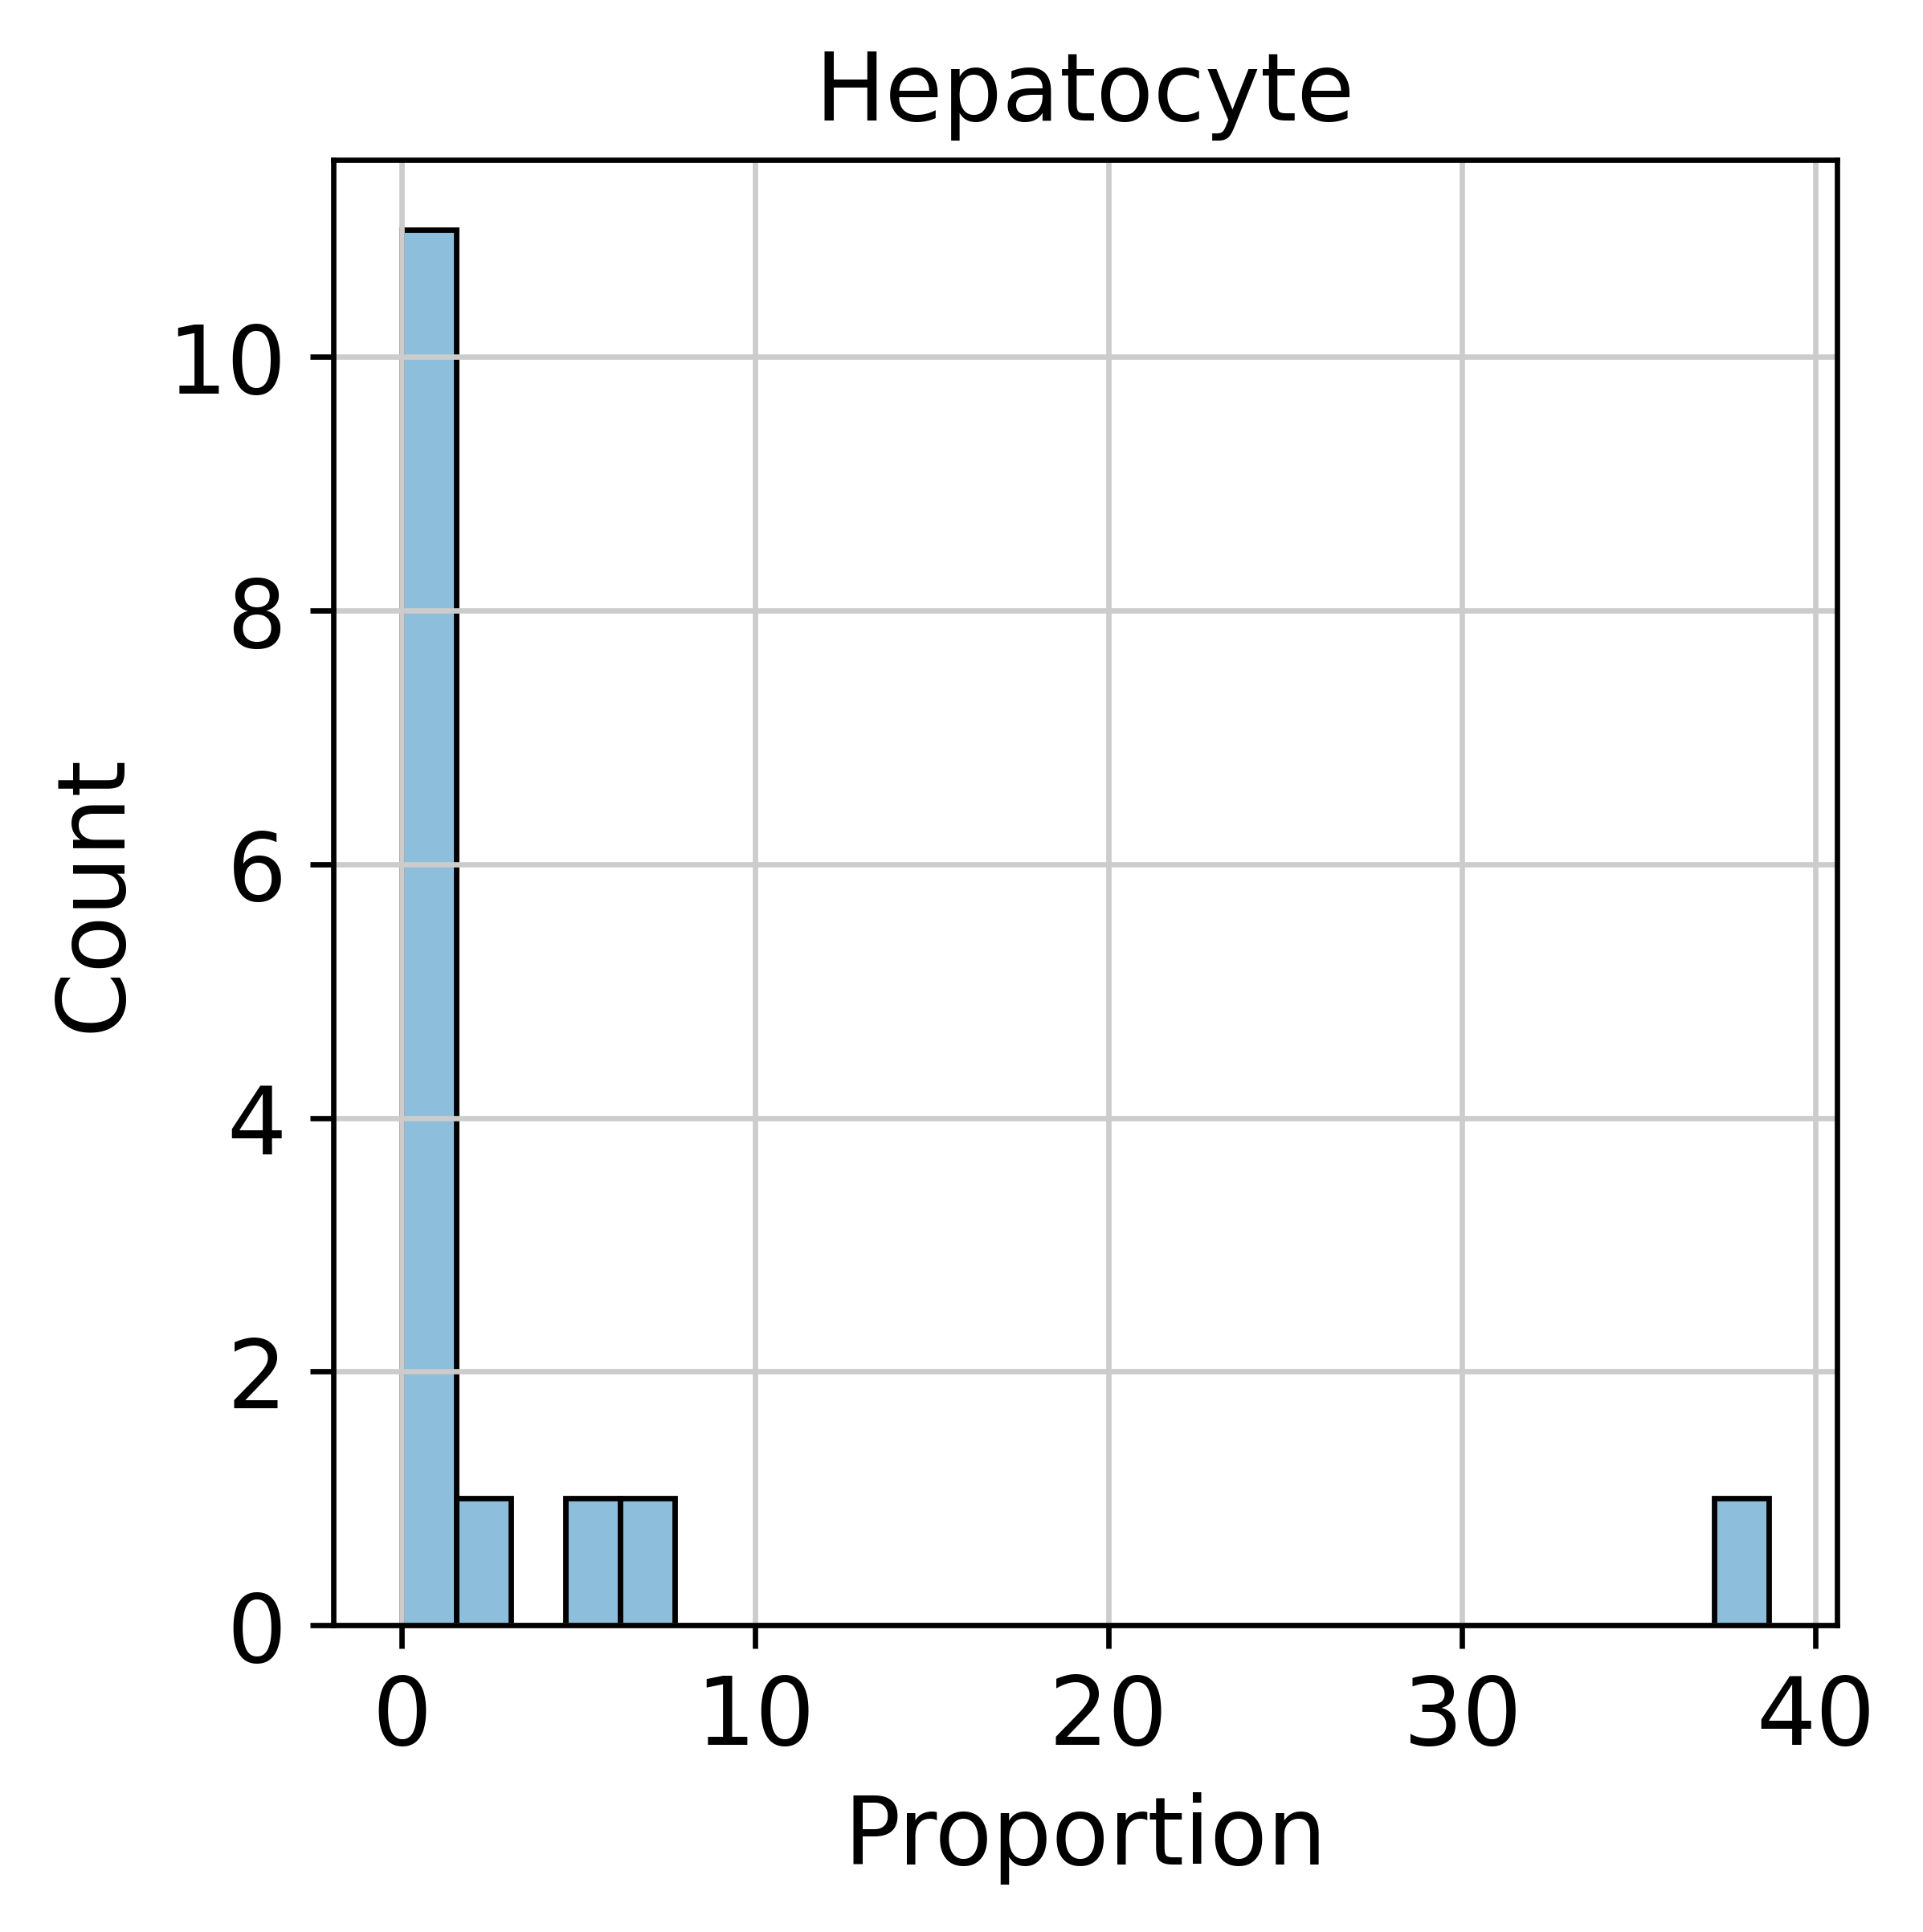

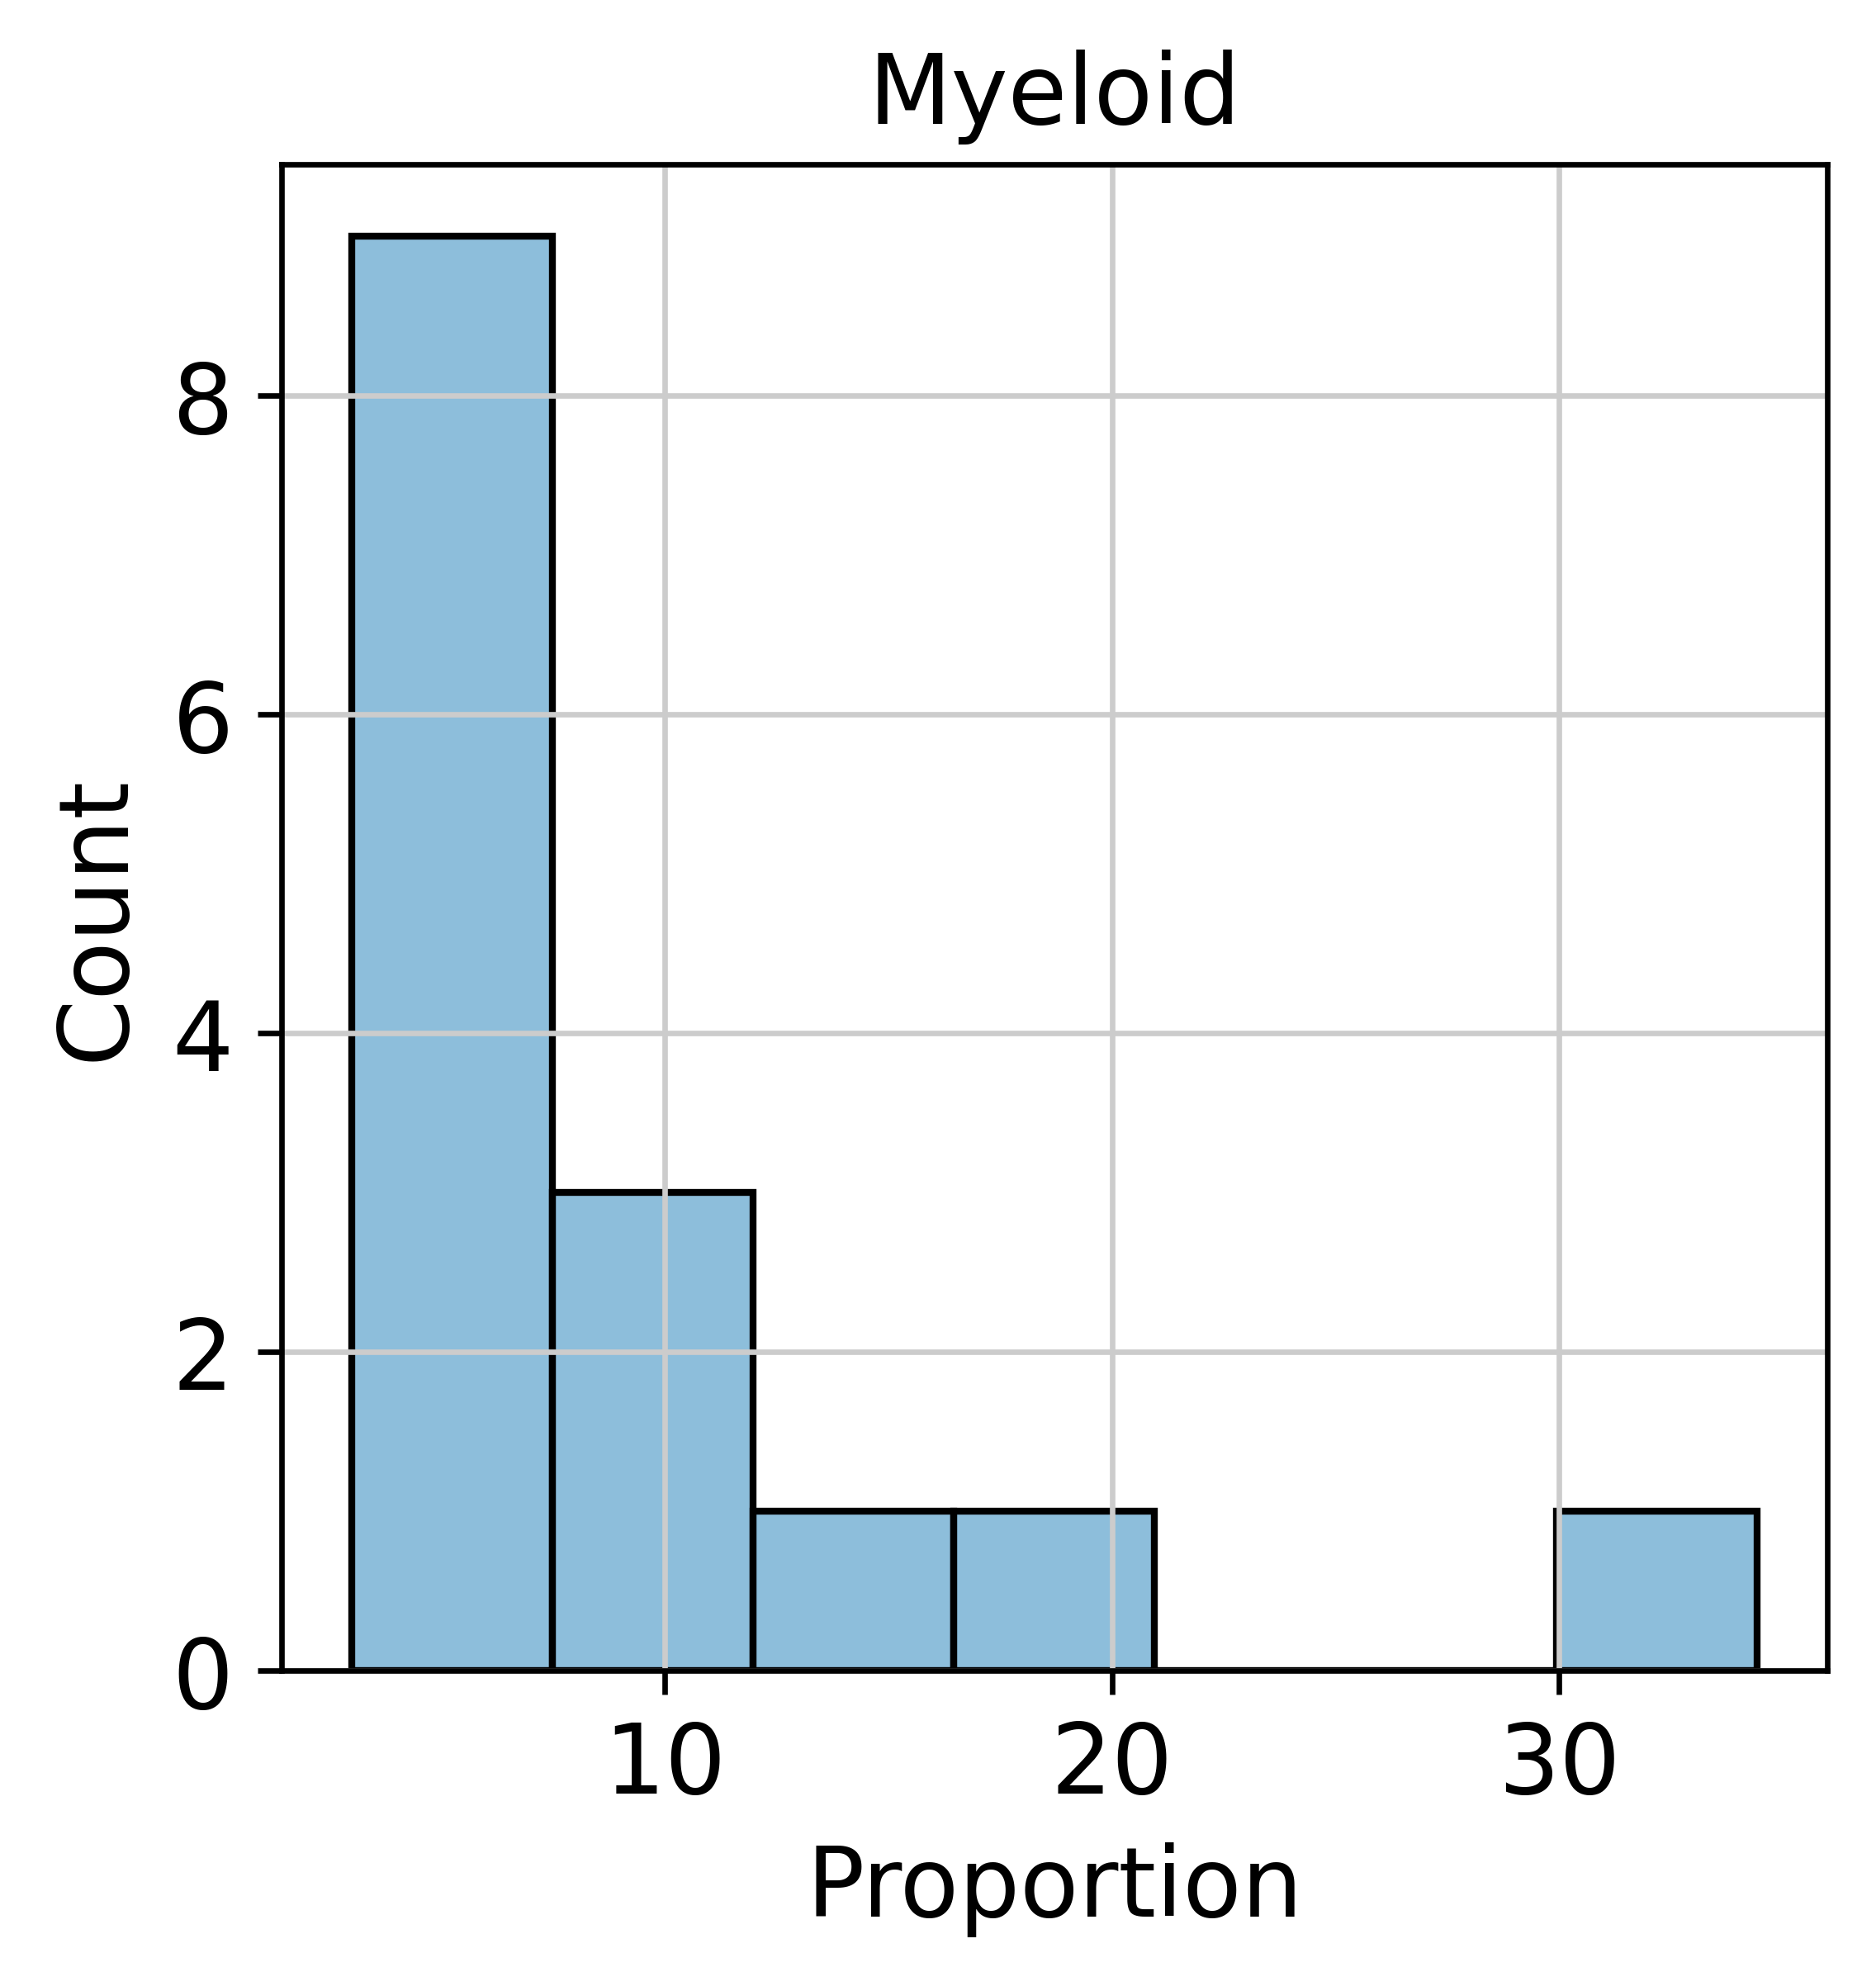

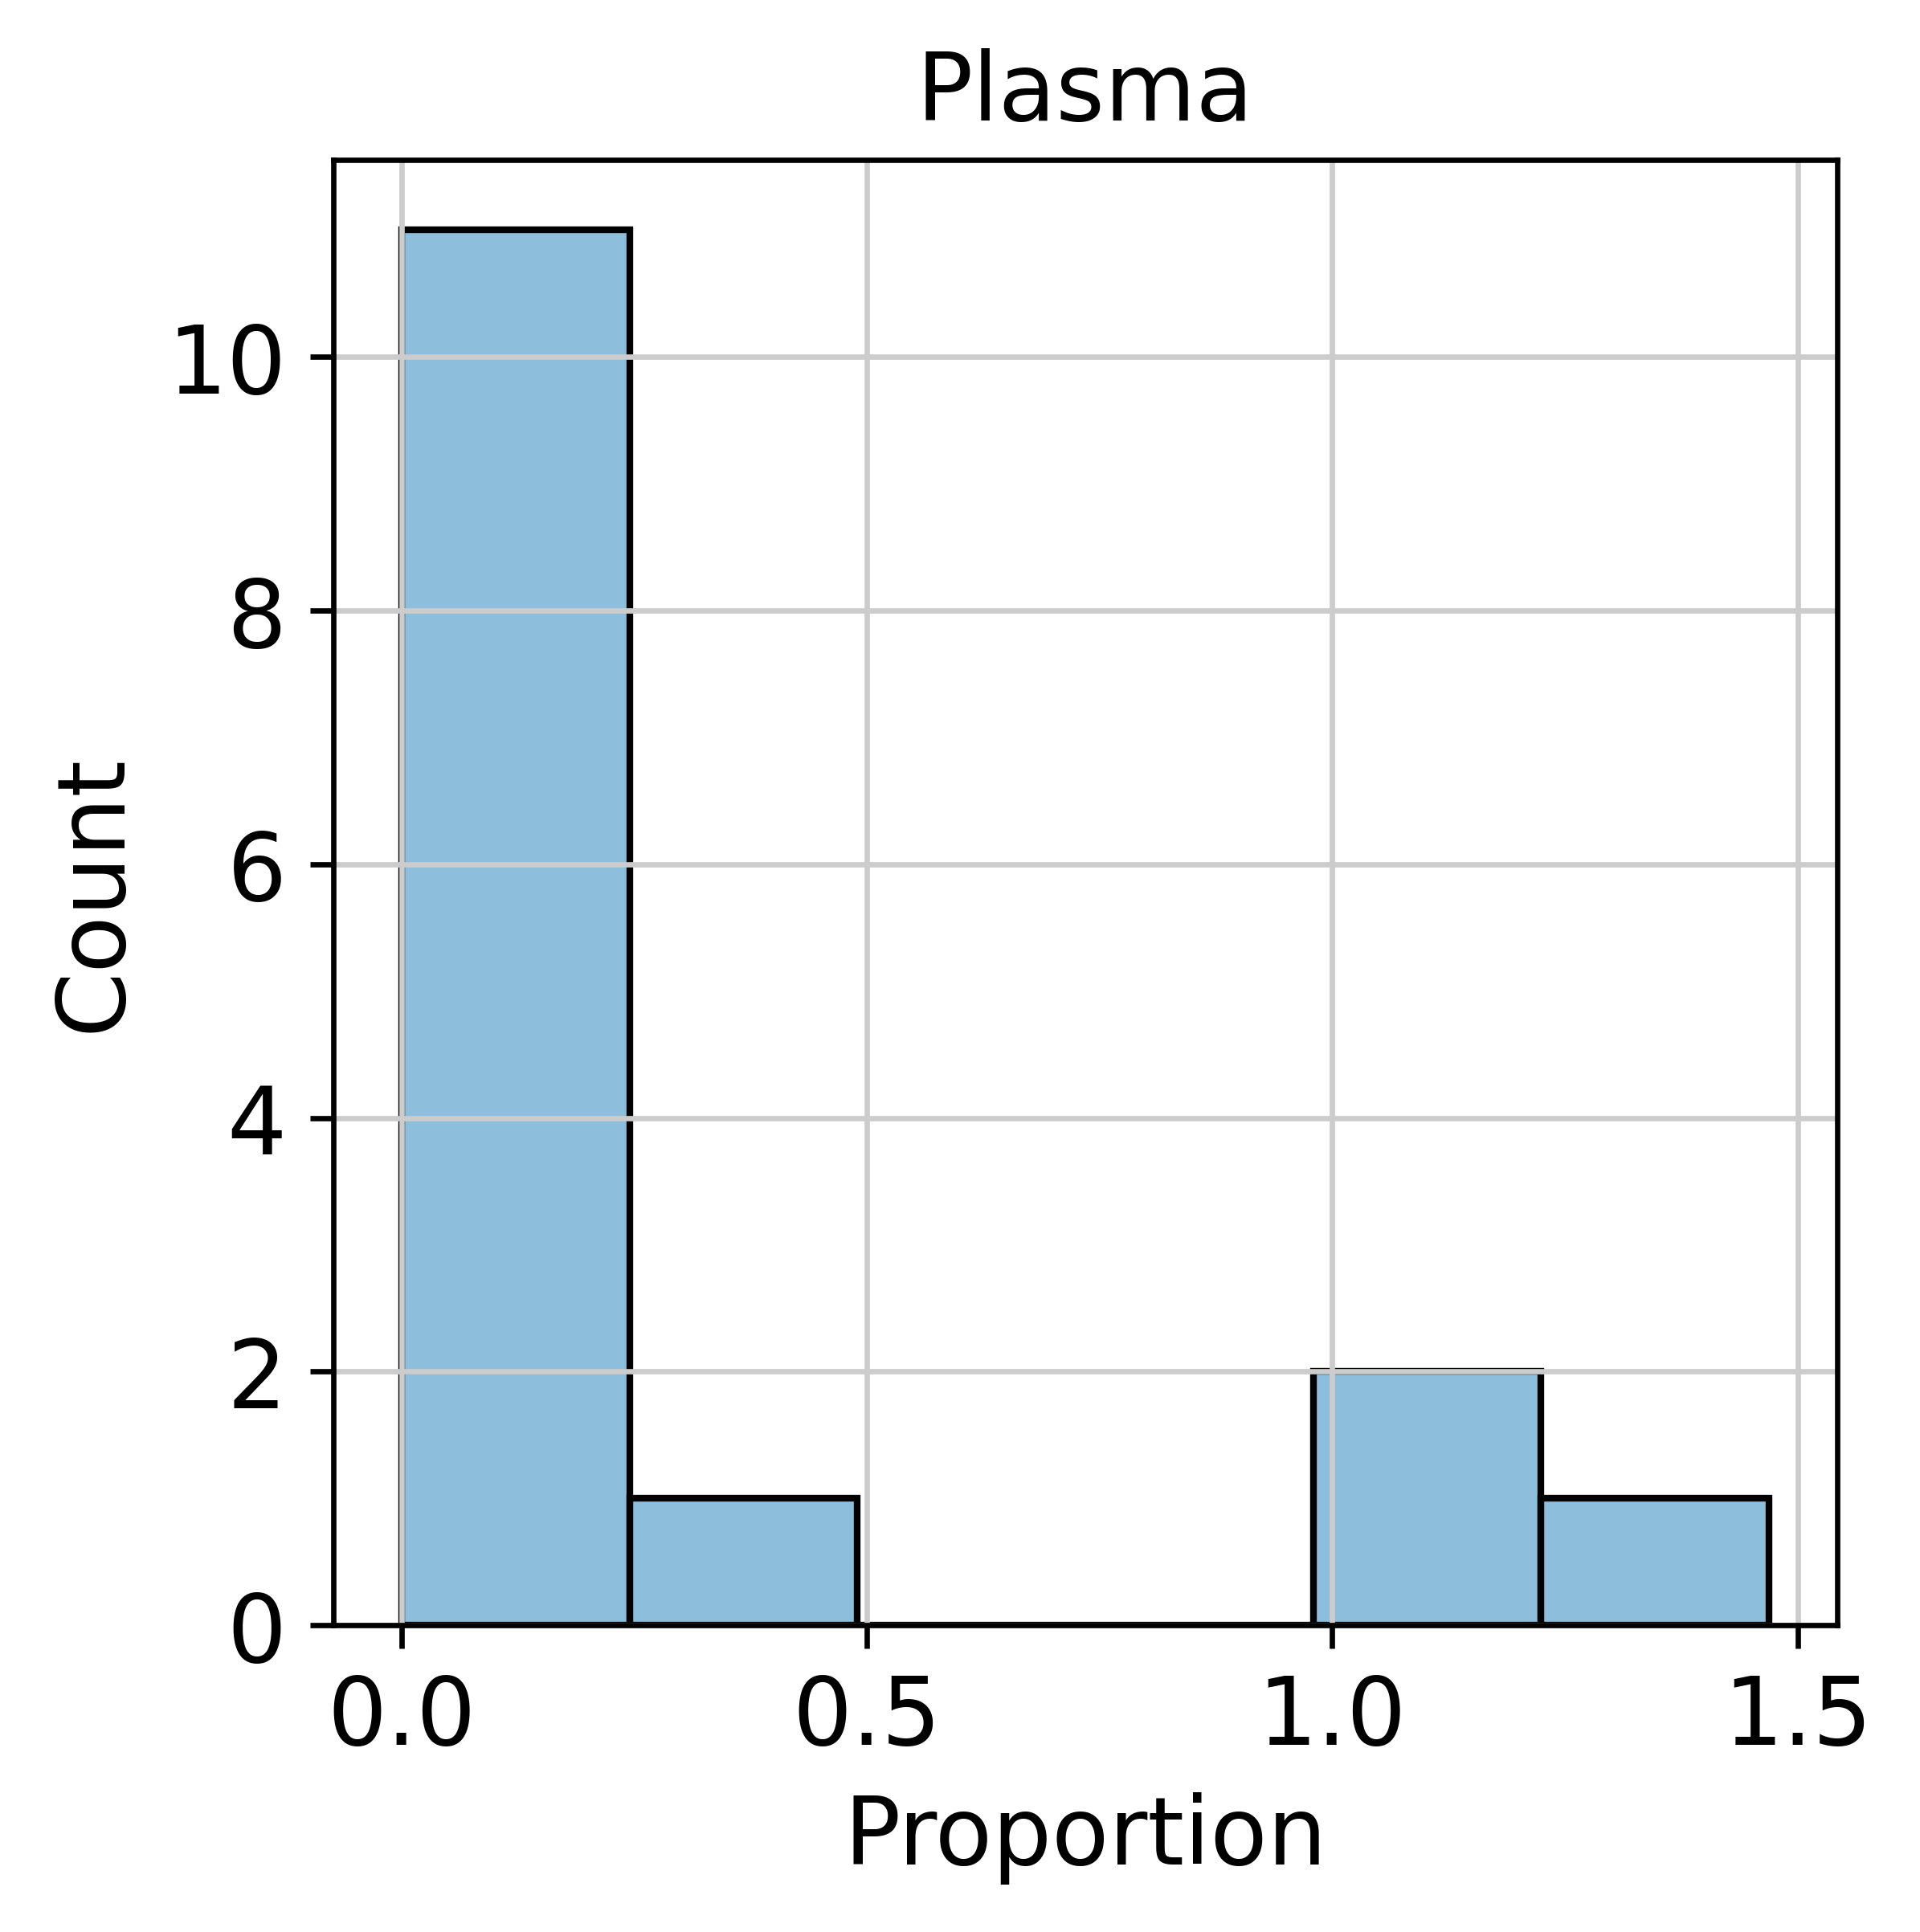

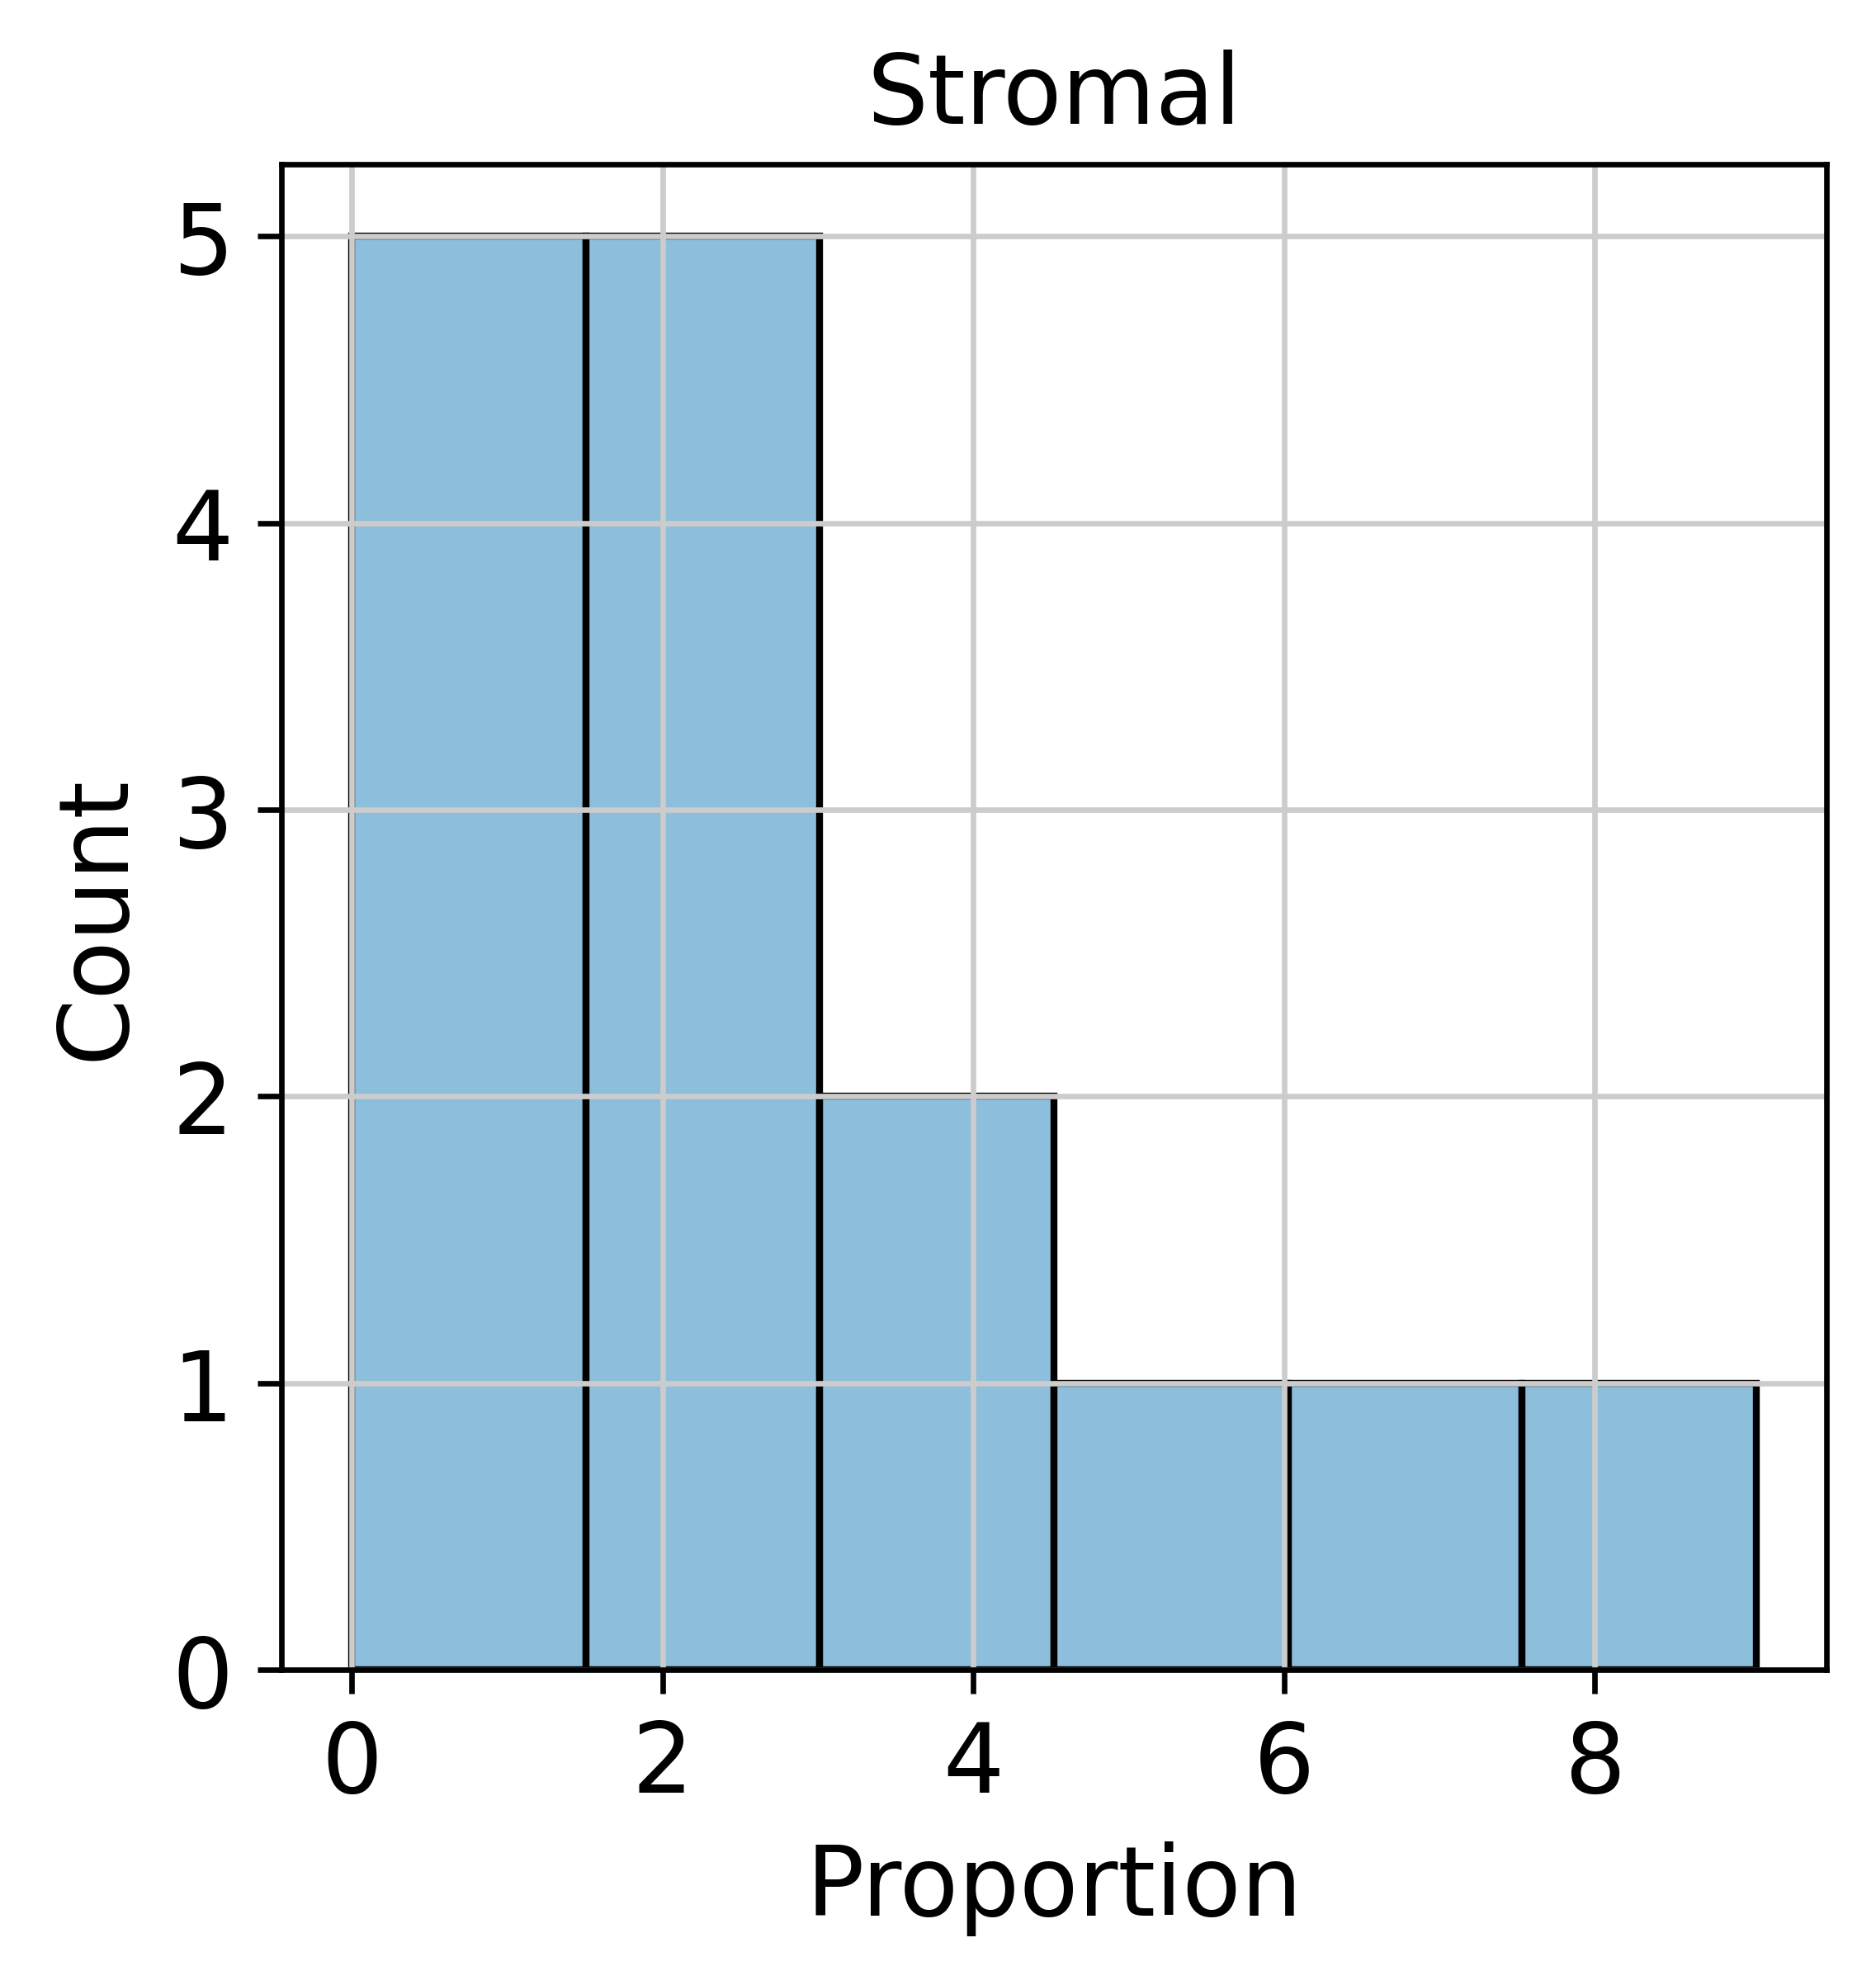

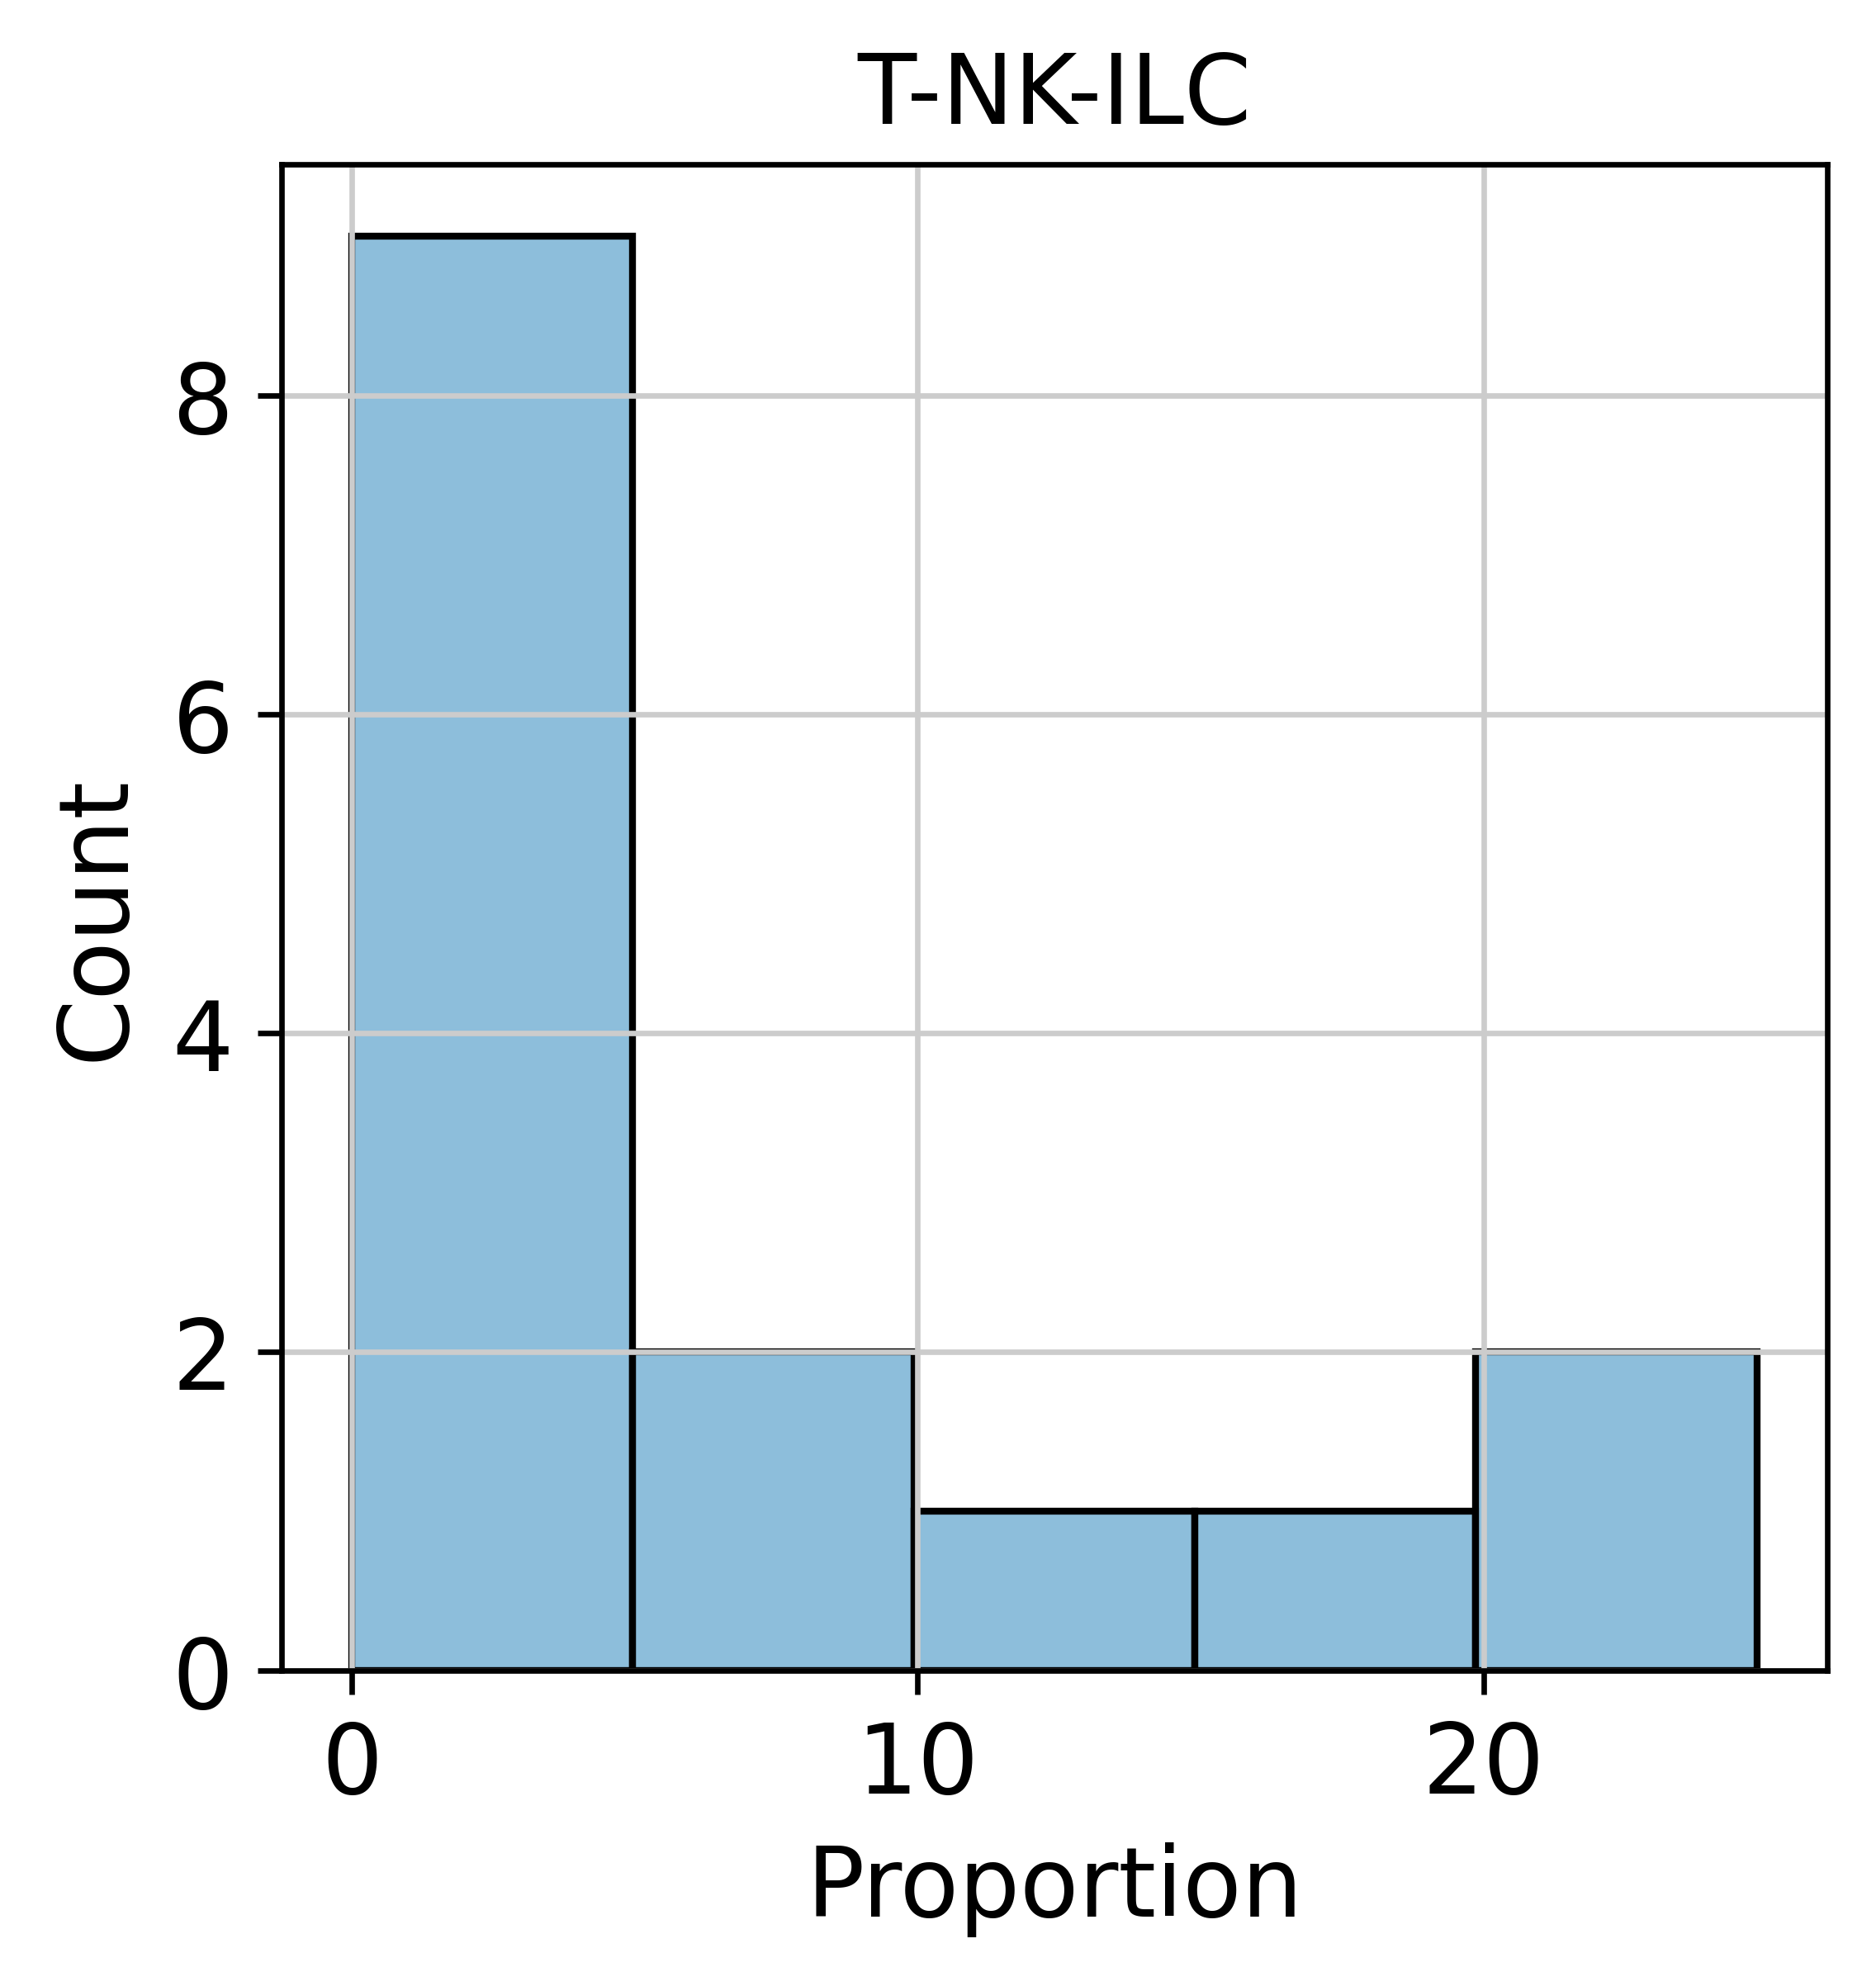

In [15]:
plot_distribution_prop_celltype(df=prop_major, name2save="major_celltypes")

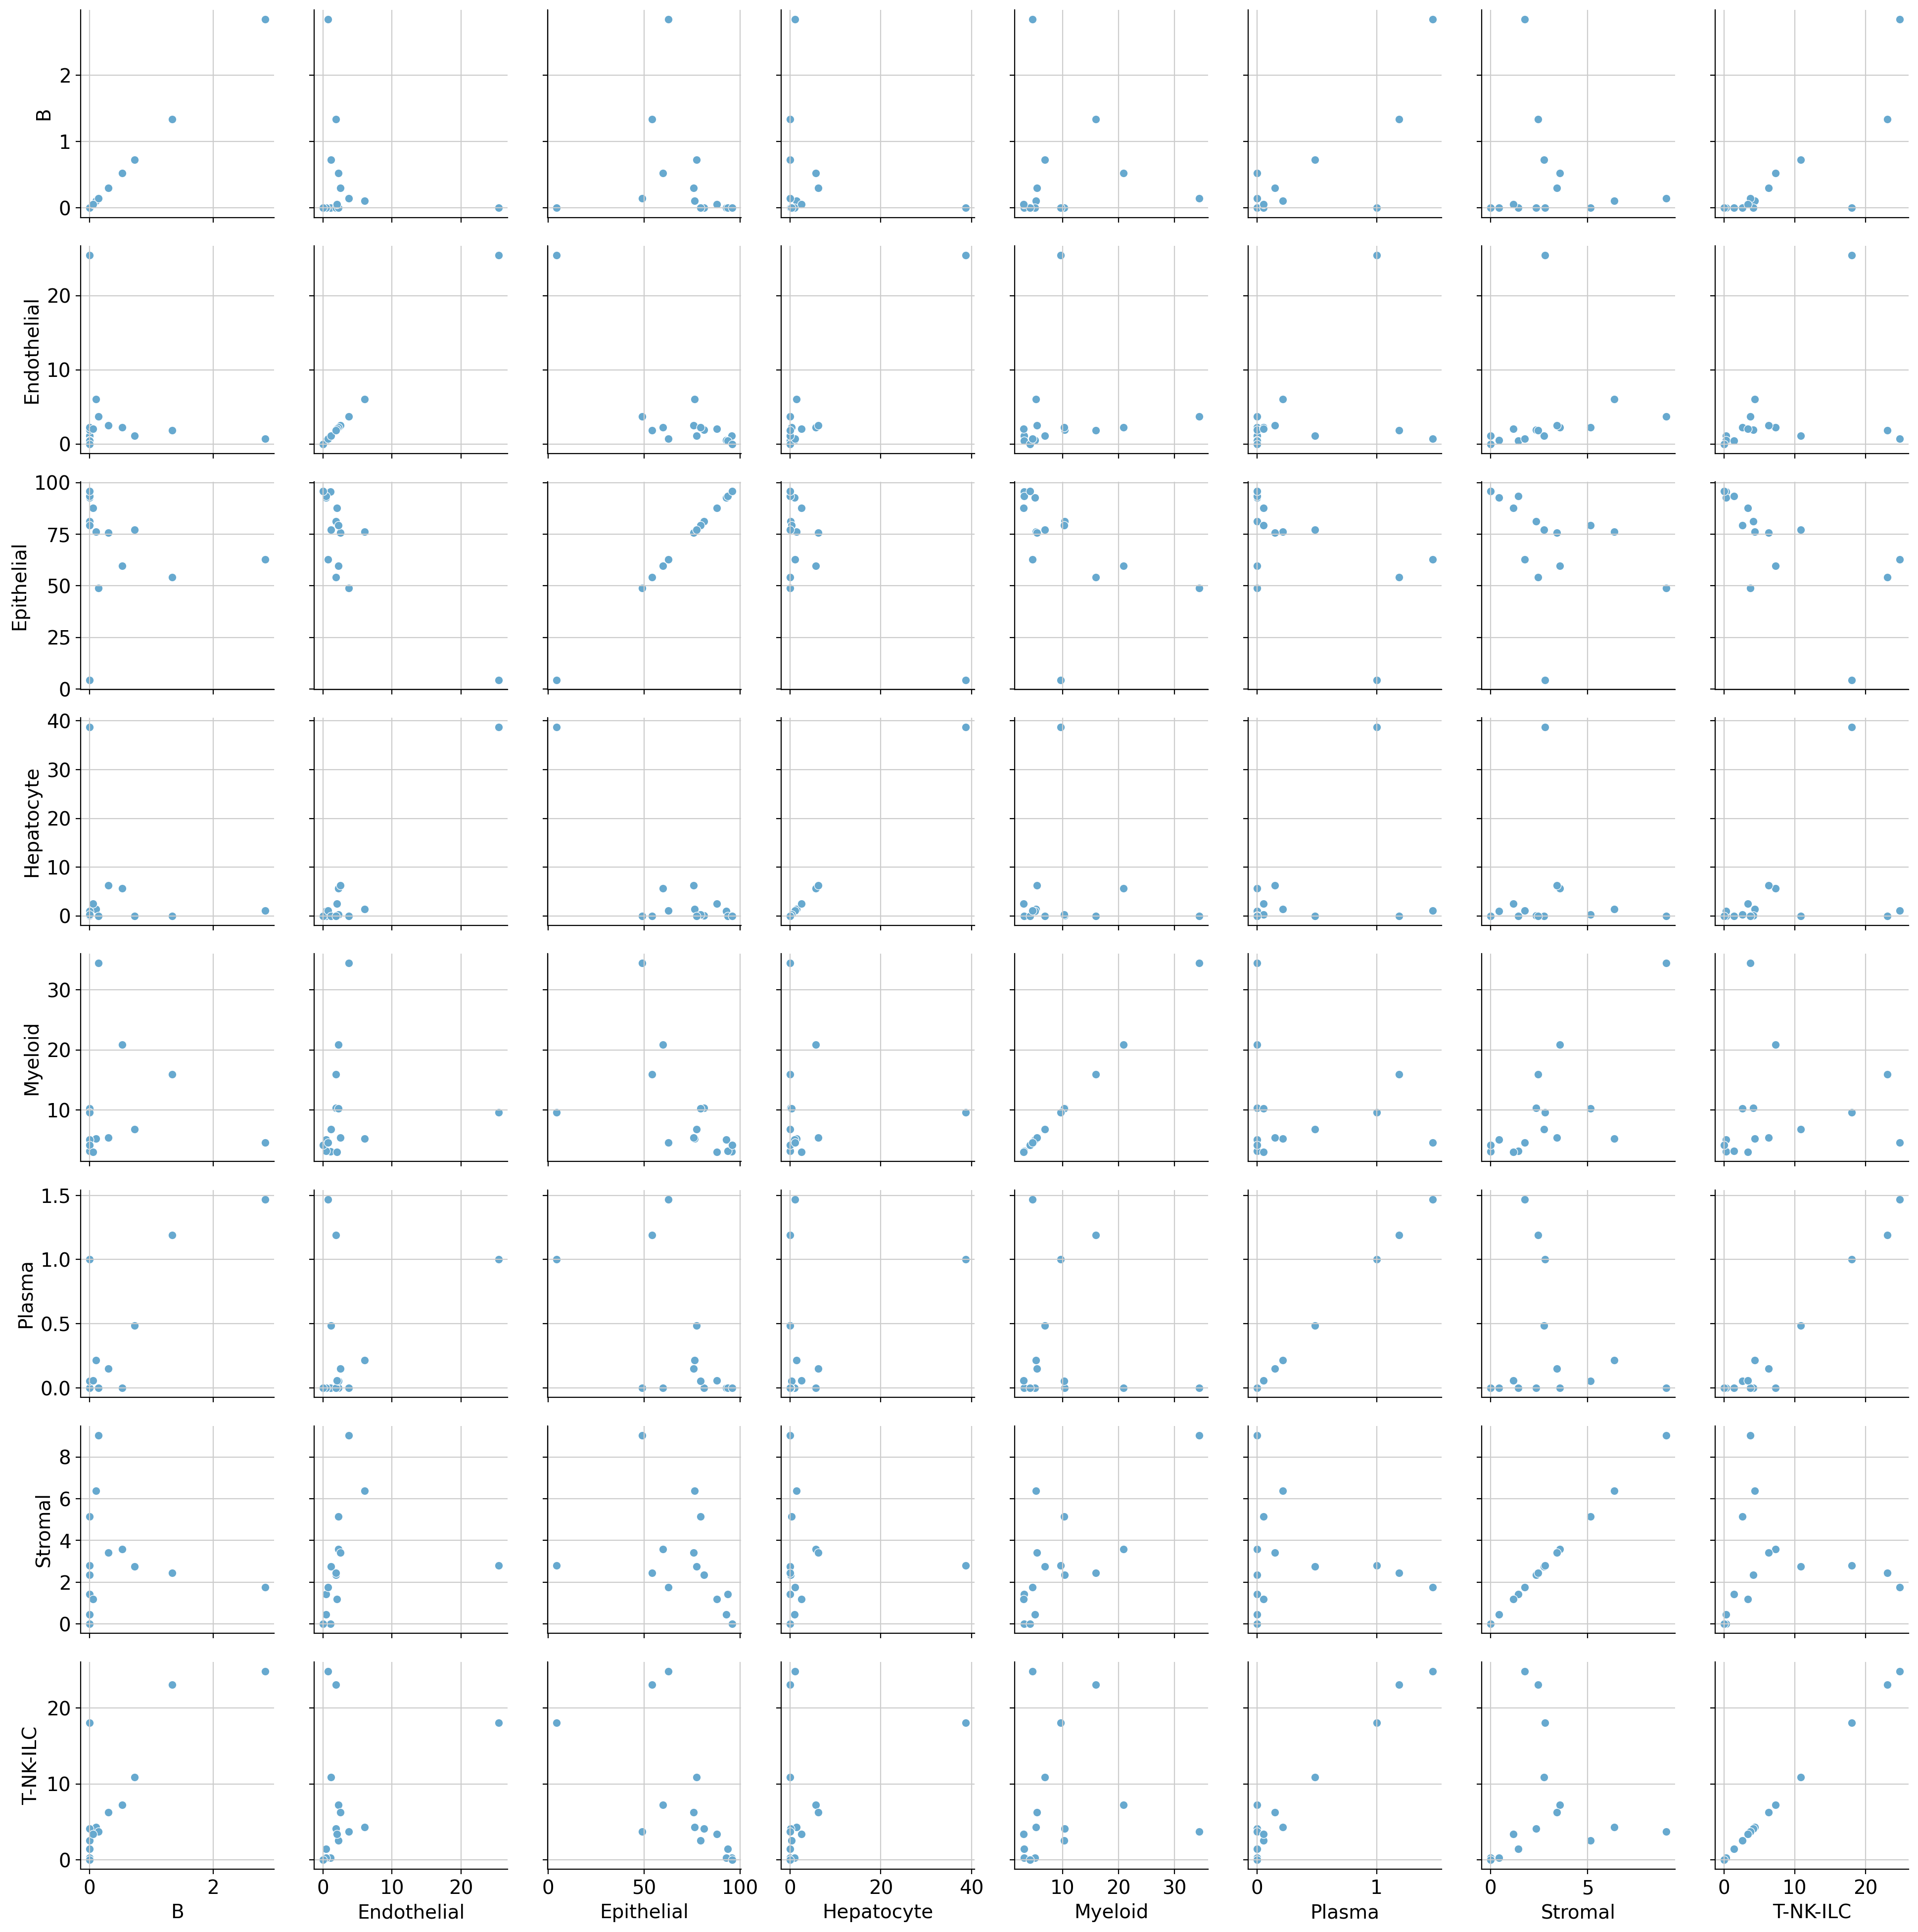

In [16]:
# plot scatterpplot to show relationship between variables
def scatterplot_celltype(df, name2save):
    g = sns.PairGrid(df)
    g.map(sns.scatterplot, color="#67A9CF")
    g.savefig(FIG2SAVE.joinpath(f"scatterplot_proportions_{name2save}.pdf"), 
                    dpi=DPI, 
                    format="pdf",
                    bbox_inches="tight")

scatterplot_celltype(prop_major, "major_celltypes")

In [21]:
def plot_correlation_heatmap(df, corr_method, name2save, figsize=(5,5)):
    corr_df = df.corr(method=corr_method)
    
    # we want to make a triangular heatmap
    # create a mask for upper triangle
    # generate a mask of ones with same shape as corr_df, converts to True with bool type
    # apply triangular, upper part is true, lower is false
    mask = np.triu(np.ones_like(a=corr_df, dtype=bool))
    
    fig, ax = plt.subplots(nrows=1,
                           ncols=1, 
                           sharey=False,
                           sharex=False,
                           dpi=DPI,
                           figsize=figsize
                          )
    sns.heatmap(data=corr_df, 
            mask=mask, 
            cmap="vlag", 
            robust=True,
            cbar_kws={'label': f'{corr_method} correlation'}, 
            square=True, 
            linewidths=.5,
            ax=ax
           )
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    fig.savefig(FIG2SAVE.joinpath(f"{corr_method}_correlation_heatmap_{name2save}.pdf"), 
                dpi=DPI, 
                format="pdf",
                bbox_inches="tight")

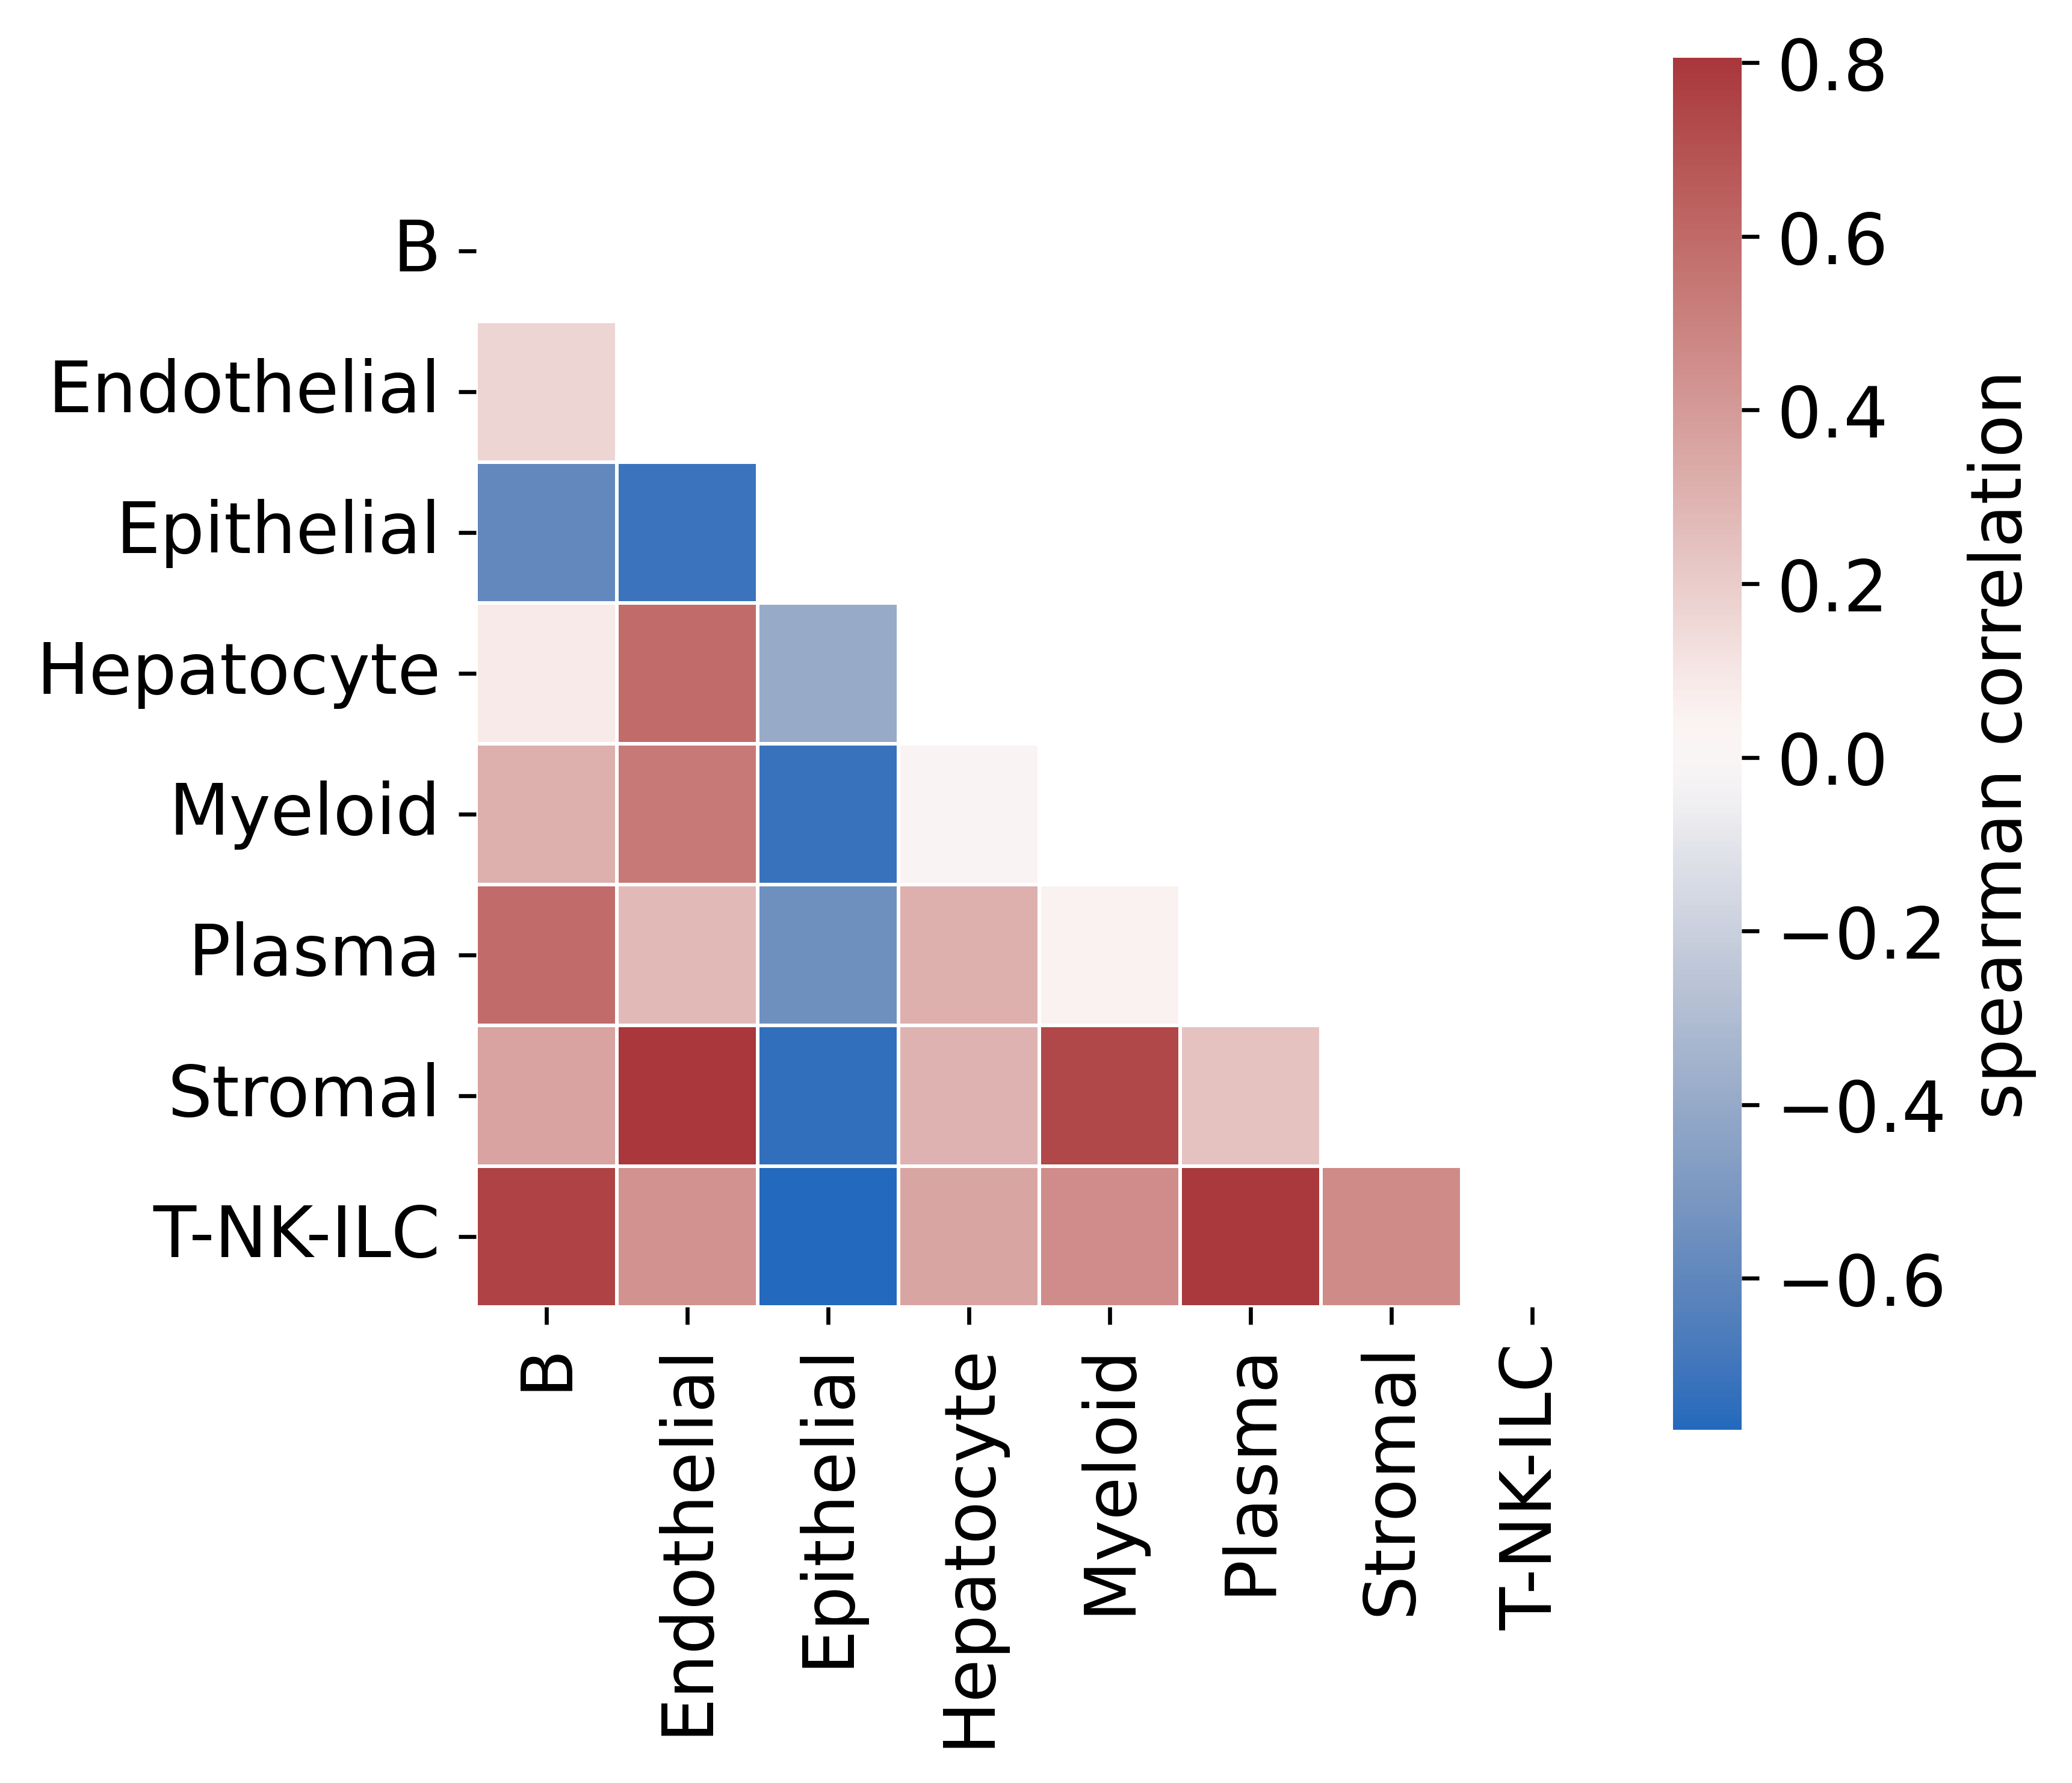

In [22]:
plot_correlation_heatmap(df=prop_major, corr_method="spearman", name2save="major_celltypes")

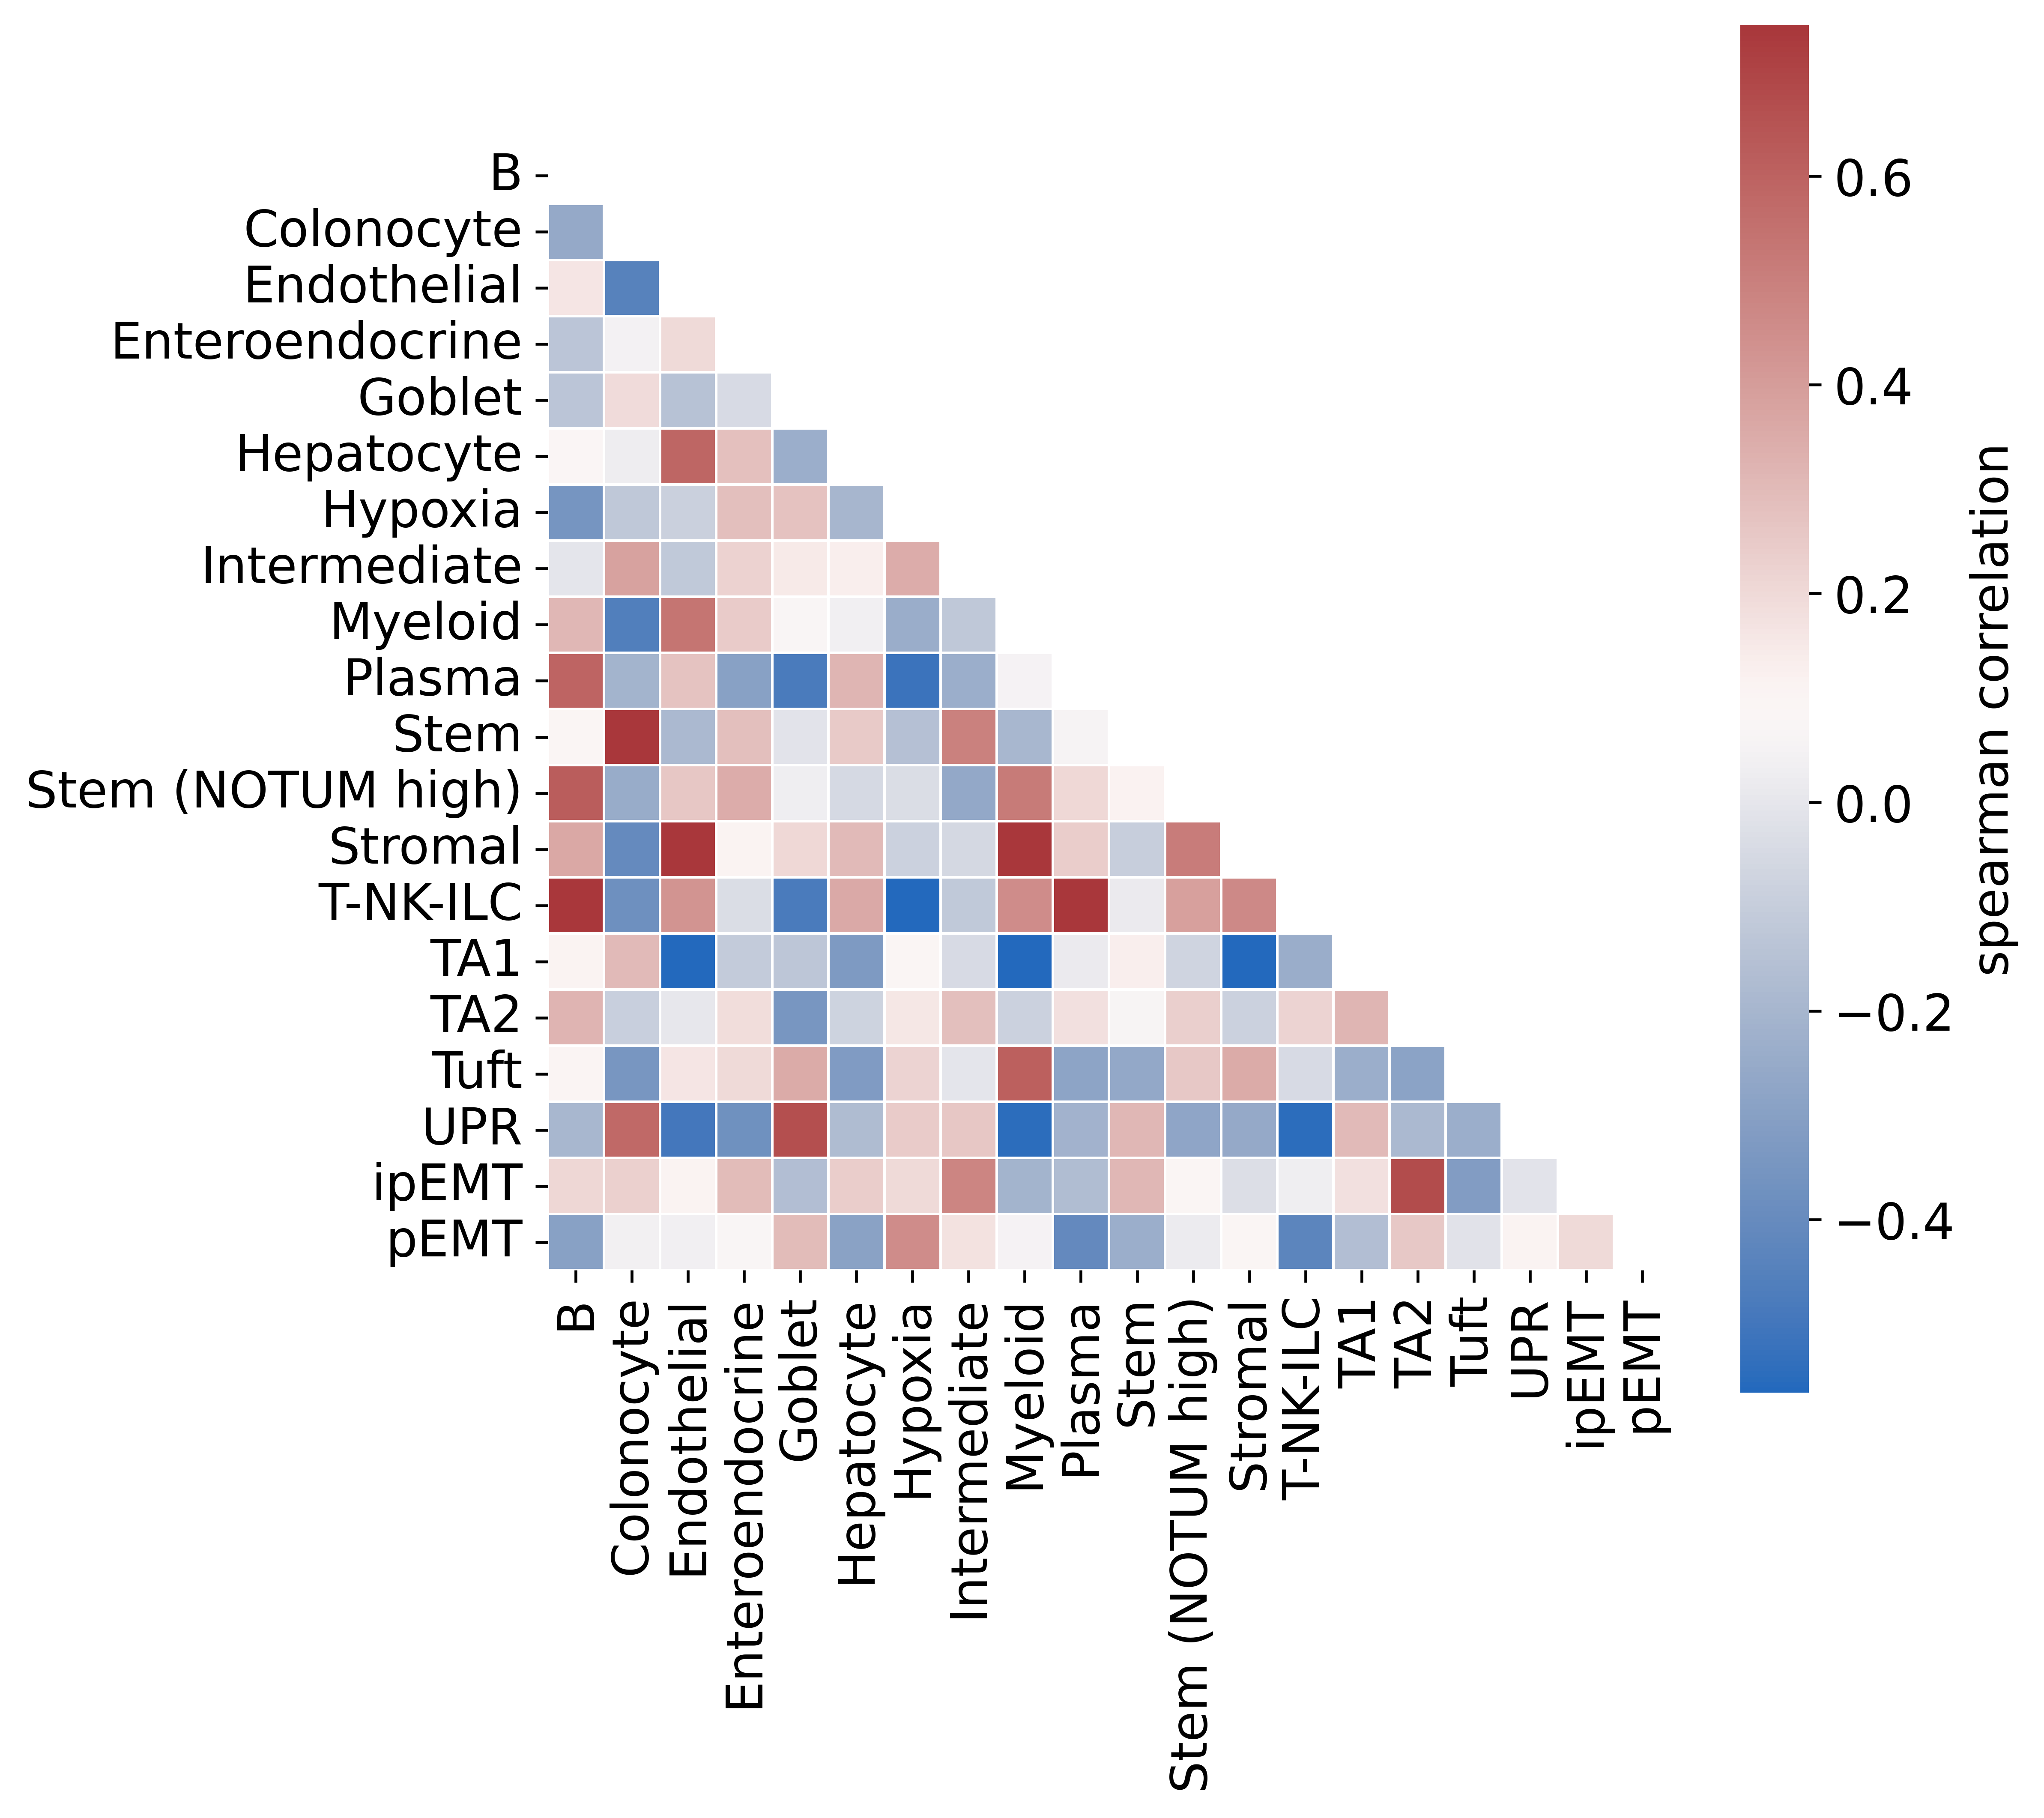

In [24]:
plot_correlation_heatmap(df=prop_majorTME_cancer_states, 
                         corr_method="spearman", 
                         name2save="major_TME_cancer_states", 
                         figsize=(7,7))

In [42]:
plot_correlation_heatmap(df=prop_subsets, 
                         corr_method="spearman", 
                         name2save="subsets", 
                         figsize=(15,15))